# Regularización, data augmentation y transfer learning con modelos convolucionales

Bibliografía:
- Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python (capítulo 14), Sebastian Rachska et al., 2022 Packt
- Deep Learning with PyTorch, Eli Stevens et al, 2020 Manning
- Deep Learning with Python (capítulo 2), Francois Chollet, 2018 Manning
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.), Aurelien Geron, 2019 O'Reilly
- Deep Learning Specialization, DeepLearning.AI, Coursera
- https://pytorch.org/tutorials

En este noteboook presentamos:
- El uso de data loaders basados en datasets de imágenes desde el sistema de archivos
- Regularización de modelos con capas dropout o de batch normalization
- Data augmentation con imágenes a partir de transformaciones
- Transfer learning
- Fine tuning de capas transferidas

Utilizamos los siguientes componentes técnicos:
- layers: Conv2D, MaxPooling2D, Flatten, Dense, Droupout, BatchNormalisation
- optimizadores: Adam
- loss functions: binary_crossentropy
- métricas de seguimiento y evaluación: accuracy
- funciones de activación: relu, sigmoid
- generadores de datos de imágenes: ImageDataGenerator
- modelos transferidos: VGG16, InceptionV3
- Uso de Api funcional de Keras para creación de modelos no secuenciales

In [1]:
import os, glob, zipfile, shutil
import requests
import time
import copy
from shutil import rmtree, copyfile
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torchvision
import torchvision.transforms as T
import torchvision
import torchvision.models as models

In [3]:
!pip install torchvision
import torchvision
import torchvision.transforms as T

from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [5]:
def reset_seed():
    random_seed = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


In [6]:
reset_seed()

## Parte 1. Obtención y preparación del dataset

Este notebook parte del hecho de que se va a ejecutar en **Google Colab**.

Bajamos la data en un zip, y lo descomprimimos.

In [7]:
if os.path.exists('/content/kagglecatsanddogs_5340.zip'):
  os.remove('/content/kagglecatsanddogs_5340.zip')

In [8]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

--2022-08-23 22:34:03--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.77.173.59, 2600:1408:c400:e89::317f, 2600:1408:c400:e93::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.77.173.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   222MB/s    in 3.8s    

2022-08-23 22:34:07 (208 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



El dataset que vamos a utilizar fue objeto de una competencia de **Kaggle** de hace unos años.
Ya descargamos el archivo zip y lo descomprimimos.
Ahora vamos a reorganizarlo para hacer varios experimentos.
Esta operación <font color="red">**solo se debe realizar una única vez** </font>.

In [9]:
ORGANIZAR_ARCHIVOS=True

In [10]:
# El directorio con los datos originales bajados
original_dataset_dir = '/content/original/'
original_dataset_cats_dir = '/content/original/PetImages/Cat'
original_dataset_dogs_dir = '/content/original/PetImages/Dog'

# El directorio con los particionamientos que utilizaremos para entrenar, validar y evaluar
base_dir = '/content/cats_and_dogs'

In [11]:
#shutil.rmtree('/content/original')
#shutil.rmtree(base_dir)

In [12]:
if os.path.exists(original_dataset_dir):
  shutil.rmtree(original_dataset_dir)

if ORGANIZAR_ARCHIVOS:
  if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

In [13]:
if os.path.exists(base_dir):
  shutil.rmtree(base_dir)

In [14]:
!unzip kagglecatsanddogs_5340.zip -d original

Streaming output truncated to the last 5000 lines.
  inflating: original/PetImages/Dog/5500.jpg  
  inflating: original/PetImages/Dog/5501.jpg  
  inflating: original/PetImages/Dog/5502.jpg  
  inflating: original/PetImages/Dog/5503.jpg  
  inflating: original/PetImages/Dog/5504.jpg  
  inflating: original/PetImages/Dog/5505.jpg  
  inflating: original/PetImages/Dog/5506.jpg  
  inflating: original/PetImages/Dog/5507.jpg  
  inflating: original/PetImages/Dog/5508.jpg  
  inflating: original/PetImages/Dog/5509.jpg  
  inflating: original/PetImages/Dog/551.jpg  
  inflating: original/PetImages/Dog/5510.jpg  
  inflating: original/PetImages/Dog/5511.jpg  
  inflating: original/PetImages/Dog/5512.jpg  
  inflating: original/PetImages/Dog/5513.jpg  
  inflating: original/PetImages/Dog/5514.jpg  
  inflating: original/PetImages/Dog/5515.jpg  
  inflating: original/PetImages/Dog/5516.jpg  
  inflating: original/PetImages/Dog/5517.jpg  
  inflating: original/PetImages/Dog/5518.jpg  
  inflatin

Se ha descargado el archivo ZIP y al descomprimirlo, todo queda en el directorio **PetImages**, dentro del cual hay dos subdirectorios **Cat** y **Dog** con imágenes.

In [15]:
os.remove("/content/original/PetImages/Cat/Thumbs.db")
os.remove("/content/original/PetImages/Dog/Thumbs.db")
os.remove("/content/original/PetImages/Dog/9041.jpg") # imagen corrupta

Veamos cuántas imágenes de cada categoría hay.

In [16]:
cats = glob.glob(f"{original_dataset_cats_dir}/*.jpg")
dogs = glob.glob(f"{original_dataset_dogs_dir}/*.jpg")

In [17]:
print('Total cat images:', len(cats))
print('Total dog images:', len(dogs))

Total cat images: 12500
Total dog images: 12499


Veamos un poco las imágenes que vamos a estar analizando (8 de gatos, 8 de perros)

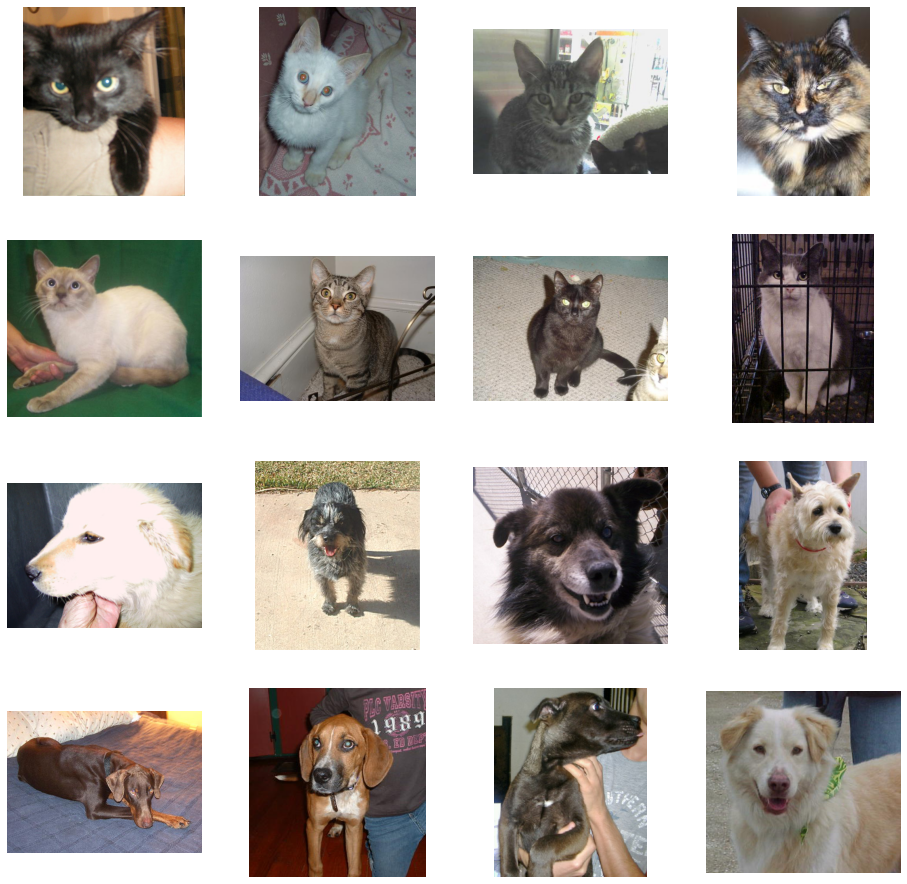

In [18]:
nrows = 4
ncols = 4
images_per_class = 8

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

next_cat_pix = cats[:images_per_class]
next_dog_pix = dogs[:images_per_class]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

Vale la pena notar que así tengamos perros y gatos como únicas dos clases, dentro de cada una de las clases vemos gran diversidad de colores, formas y tamaños de animales.

Vamos a crear una estructura de directorios (train, test), cada uno con dos subdirectorios (cats, dogs) con las imágenes correspondientes.
Comenzamos por crear la estructura de directorios.

In [19]:
TRAIN_DIR = os.path.join(base_dir, 'train')
TEST_DIR = os.path.join(base_dir, 'test')

CAT_SOURCE_DIR = original_dataset_cats_dir
TRAIN_CATS_DIR = os.path.join(TRAIN_DIR, 'cats')
TEST_CATS_DIR = os.path.join(TEST_DIR, 'cats')

DOG_SOURCE_DIR = original_dataset_dogs_dir
TRAIN_DOGS_DIR = os.path.join(TRAIN_DIR, 'dogs')
TEST_DOGS_DIR = os.path.join(TEST_DIR, 'dogs')

if ORGANIZAR_ARCHIVOS:
  if not os.path.exists(base_dir):
    os.mkdir(base_dir)
  if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
  if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)
  if not os.path.exists(TRAIN_CATS_DIR):
    os.mkdir(TRAIN_CATS_DIR)
  if not os.path.exists(TEST_CATS_DIR):
    os.mkdir(TEST_CATS_DIR)
  if not os.path.exists(TRAIN_DOGS_DIR):
    os.mkdir(TRAIN_DOGS_DIR)
  if not os.path.exists(TEST_DOGS_DIR):
    os.mkdir(TEST_DOGS_DIR)

Vamos a crear una función que nos permita particionar las imágenes de base en los dos subdirectorios de manera aleatoria.
Va a recibir:
- source: directorio con las imágenes de base
- train: directorio donde quedarán las imágenes a utilizar durante el entrenamiento
- test: directorio donde quedarán las imágenes a utilizar para evaluar el modelo entrenado
- split_size: porcentaje de las imágenes a conservar para el entrenamiento en el directorio de train; el complemento quedará en el directorio de test
- dest_size: tamaño total del dataset final, incluyendo training y test, por defecto es el 100%. Si se establece este valor superior al número de imágenes totales, se capea a las imágenes disponibles

Vamos a crear una estructura de directorios para un dataset con la totalidad de imágenes, con un 90% de imágenes en el test set.
Los archivos de tamaño cero, o de tipos diferentes a imágenes serán ignorados.

In [20]:
def split_data(SOURCE, TRAIN, TEST, SPLIT_SIZE, DEST_SIZE=None):
    #Obtenemos todos los nombre de todos los archivos que se encuentran en la fuente de datos
    dataset_filenames = []
    for filename in os.listdir(SOURCE):
        #check archivo vacío
        filename_complete = os.path.join(SOURCE, filename)
        if os.path.getsize(filename_complete)==0:
            print(filename_complete, os.path.getsize(filename_complete))
            continue
        
        #check archivo no es imágen
        ext = os.path.splitext(filename)[1]
        if not ext.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(filename_complete, os.path.getsize(filename_complete))
            continue

        dataset_filenames.append(filename)

    if DEST_SIZE is None or len(dataset_filenames) < DEST_SIZE:
        DEST_SIZE = len(dataset_filenames)
    
    #barajamos el conjunto de nombres de archivos y lo separamos en training y testing sets
    dataset_filenames_shuffled = random.sample(dataset_filenames, len(dataset_filenames))
    train = dataset_filenames_shuffled[0:int(DEST_SIZE * SPLIT_SIZE)]
    test = dataset_filenames_shuffled[int(DEST_SIZE * SPLIT_SIZE):DEST_SIZE]
    
    print(f"Se crea un dataset de {DEST_SIZE} instancias, con {int(DEST_SIZE * SPLIT_SIZE)} en training")

    #copiamos los archivos a los respectivos directorios
    for filename in train:
        filename_source = os.path.join(SOURCE, filename)
        filename_destination = os.path.join(TRAIN, filename)
        shutil.copyfile(filename_source, filename_destination)

    for filename in test:
        filename_source = os.path.join(SOURCE, filename)
        filename_destination = os.path.join(TEST, filename)
        shutil.copyfile(filename_source, filename_destination)

In [21]:
if ORGANIZAR_ARCHIVOS:
    random.seed(42)
    np.random.seed(42)
    split_size = .9
    split_data(CAT_SOURCE_DIR, TRAIN_CATS_DIR, TEST_CATS_DIR, split_size)
    split_data(DOG_SOURCE_DIR, TRAIN_DOGS_DIR, TEST_DOGS_DIR, split_size)

/content/original/PetImages/Cat/666.jpg 0
Se crea un dataset de 12499 instancias, con 11249 en training
/content/original/PetImages/Dog/11702.jpg 0
Se crea un dataset de 12498 instancias, con 11248 en training


In [22]:
print('Total cat train images:', len(os.listdir(TRAIN_CATS_DIR)))
print('Total cat test images:', len(os.listdir(TEST_CATS_DIR)))
print('Total dog train images:', len(os.listdir(TRAIN_DOGS_DIR)))
print('Total dog test images:', len(os.listdir(TEST_DOGS_DIR)))

Total cat train images: 11249
Total cat test images: 1250
Total dog train images: 11248
Total dog test images: 1250


Vamos también a crear una estructura de directorios alterntiva con un dataset reducido (2000 imágenes de training y 1000 de test), esto nos permitirá analizar las implicaciones del tamaño del dataset de entrenamiento en el modelo.

In [23]:
base_dir_small= '/content/cats_and_dogs_small'

In [24]:
#shutil.rmtree(base_dir_small)

In [25]:
TRAIN_SMALL_DIR = os.path.join(base_dir_small, 'train')
TEST_SMALL_DIR = os.path.join(base_dir_small, 'test')

CAT_SOURCE_DIR = original_dataset_cats_dir
TRAIN_CATS_SMALL_DIR = os.path.join(TRAIN_SMALL_DIR, 'cats')
TEST_CATS_SMALL_DIR = os.path.join(TEST_SMALL_DIR, 'cats')

DOG_SOURCE_DIR = original_dataset_dogs_dir
TRAIN_DOGS_SMALL_DIR = os.path.join(TRAIN_SMALL_DIR, 'dogs')
TEST_DOGS_SMALL_DIR = os.path.join(TEST_SMALL_DIR, 'dogs')

if ORGANIZAR_ARCHIVOS:
    # Creamos una estructura de directorios con un primer nivel separando las imágenes de train y de test, y otro con un subdirectorio para cada categoria de imágenes
    if not os.path.exists(base_dir_small):
      os.mkdir(base_dir_small)
    if not os.path.exists(TRAIN_SMALL_DIR):
      os.mkdir(TRAIN_SMALL_DIR)
    if not os.path.exists(TEST_SMALL_DIR):
      os.mkdir(TEST_SMALL_DIR)
    if not os.path.exists(TRAIN_CATS_SMALL_DIR):
      os.mkdir(TRAIN_CATS_SMALL_DIR)
    if not os.path.exists(TEST_CATS_SMALL_DIR):
      os.mkdir(TEST_CATS_SMALL_DIR)
    if not os.path.exists(TRAIN_DOGS_SMALL_DIR):
      os.mkdir(TRAIN_DOGS_SMALL_DIR)
    if not os.path.exists(TEST_DOGS_SMALL_DIR):
      os.mkdir(TEST_DOGS_SMALL_DIR)

Utilizamos la función split para escoger las imágenes del dataset reducido al azar, con 1500 imágenes para cada categoría, 1000 de train y 500 de test.

In [26]:
if ORGANIZAR_ARCHIVOS:
    random.seed(42)
    np.random.seed(42)
    dataset_size=1500
    split_size = 0.66667
    split_data(CAT_SOURCE_DIR, TRAIN_CATS_SMALL_DIR, TEST_CATS_SMALL_DIR, split_size, dataset_size)
    split_data(DOG_SOURCE_DIR, TRAIN_DOGS_SMALL_DIR, TEST_DOGS_SMALL_DIR, split_size, dataset_size)

/content/original/PetImages/Cat/666.jpg 0
Se crea un dataset de 1500 instancias, con 1000 en training
/content/original/PetImages/Dog/11702.jpg 0
Se crea un dataset de 1500 instancias, con 1000 en training


In [27]:
print('Total cat train images:', len(os.listdir(TRAIN_CATS_SMALL_DIR)))
print('Total cat test images:', len(os.listdir(TEST_CATS_SMALL_DIR)))
print('Total dog train images:', len(os.listdir(TRAIN_DOGS_SMALL_DIR)))
print('Total dog test images:', len(os.listdir(TEST_DOGS_SMALL_DIR)))

Total cat train images: 1000
Total cat test images: 500
Total dog train images: 1000
Total dog test images: 500


## Parte 2. Carga de imágenes

In [28]:
TRAIN_SMALL_DIR

'/content/cats_and_dogs_small/train'

Vamos a utilizar una instancia de la clase ```torchvision.datasets.ImageFolder``` para cargar las imágenes del training set y del test set; cada uno en uno terminará en una instancia de la clase ```torchvision.datasets.Dataset```.
Esta clase permite cargar imágenes desde un directorio donde se contiene un subdirectorio para cada clase.
En nuestro caso, tendremos el directorio "train", con dos subdirectorios "cats" y "dogs", uno por cada clase.

Vamos a cargar las imágenes de tal manera que tengan todas la misma forma (150 pixeles de alto y ancho), utilizando instancias de ```torchvision.transforforms.Resize()```.

In [29]:
IMG_SIZE=150

In [30]:
TRANSFORM_IMG = torchvision.transforms.Compose([    
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
])

In [31]:
train_data_small = torchvision.datasets.ImageFolder(root=TRAIN_SMALL_DIR, transform=TRANSFORM_IMG)
test_data_small = torchvision.datasets.ImageFolder(root=TEST_SMALL_DIR, transform=TRANSFORM_IMG)

In [32]:
train_data_small

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/cats_and_dogs_small/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [33]:
train_data_small.classes

['cats', 'dogs']

In [34]:
print(train_data_small.imgs[0:3])
print(train_data_small.targets[0:3])

[('/content/cats_and_dogs_small/train/cats/10.jpg', 0), ('/content/cats_and_dogs_small/train/cats/10023.jpg', 0), ('/content/cats_and_dogs_small/train/cats/10043.jpg', 0)]
[0, 0, 0]


In [35]:
print(train_data_small.imgs[-3:])
print(train_data_small.targets[-3:])

[('/content/cats_and_dogs_small/train/dogs/9942.jpg', 1), ('/content/cats_and_dogs_small/train/dogs/9967.jpg', 1), ('/content/cats_and_dogs_small/train/dogs/9995.jpg', 1)]
[1, 1, 1]


Ahora que ya tenemos las dos instancias de ```Dataset```, creamos los ```DataLoader``` correspondientes. Establecemos un batch size de 32 imágenes

In [36]:
BATCH_SIZE=16

In [37]:
train_data_loader_small = torch.utils.data.DataLoader(train_data_small, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_data_loader_small = torch.utils.data.DataLoader(test_data_small, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 

Mas adelante crearemos más datasets y dataloaders para ilustrar el **data augmentation** y para poder además cargar el dataset completo.

## Parte 3. Funciones para el entrenamiento y evaluación de modelos

En esta sección recopilamos las funciones que utilizaremos mas adelante para la búsqueda de los mejores modelos, analizando las diferentes técnicas de regularización y optimización del entrenamiento.

Creamos entonces la función encargada de realizar los ciclos de entrenamiento a partir de batches sobre el ```DataLoader``` de training que:
- Por defecto define una función de pérdida ```nn.BCELoss()``` que recibe las probabilidades de clasificación, y calcula el accuracy teniendo en cuenta que el modelo retorna una sola probabilidad (de la clase 1), por lo que evalua si las predicciones son superiores a 0.5 para asignarles la clase e, o 0 de lo contrario. Se puede modificar enviando la función como parámetro; esto puede ser necesario si el modelo en cuestión no devuleve probabilidades sino logits.
- permite definir el porcentaje de datos que se utilizará para validación durante cada epoca.
- aplica técnica de creación de **checkpoints** del modelo previamente presentada en el notebook anterior
- implementa la técnica de **early stopping** en el ciclo, estableciendo 
    - **early_stopping_acc_training**: una meta del accuracy sobre el training set a alcanzar antes de suspender el entrenamiento.
    - **early_stopping_loss_val_patience**: un número de épocas máximo a iterar sin mejoras en el loss de validación. Requiere que se tenga un set de validación, en caso contrario, no se aplica.
- aplica técnica de **data augmentation** sobre el training set para reducir un poco mas el overfitting modificando levemente las imágenes del dataset de entrenamiento


In [38]:
def train_model(modelo, train_dataset, train_batch_size=128, learning_rate = 1e-3, epocas=30, loss_fn=nn.BCELoss(), val_split=0, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=-1, transformaciones=None, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :loss_fn:
        función de pérdida a utilizar. Si no se especifica, se usa BCELoss
    :val_split:
        porcentaje del dataset de entrenamiento dedicado a la validación, su valor será limitado al intervalo [0 (sin validación), 0.5]
    :early_stopping_acc_training:
        umbral máximo de accuracy sobre el training set, si se sobrepasa durante una época, se parará el entrenamiento, limitando el overfitting
    :early_stopping_loss_val_patience:
        número de épocas de paciencia a esperar una mejora del val loss antes de suspender el entrenamiento. -1 implica que no se aplica
    :transformaciones:
        transformaciones a realizar sobre el training set si se quiere aplicar data augmentation
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses y accuracies del val set después de cada época
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    if val_split > 0.5:
        val_split=0.5

    if val_split < 0:
        val_split=0

    if val_split > 0:
        num_training_instances = int(len(train_dataset)*(1-val_split))
        num_validation_instances = len(train_dataset) - num_training_instances
        print(f"val_split: {val_split}, num_training_instances {num_training_instances}, num_validation_instances {num_validation_instances}")
        training_subset, validation_subset = torch.utils.data.random_split(
            train_dataset, [num_training_instances, num_validation_instances])
    
        train_loader = torch.utils.data.DataLoader(
            training_subset, batch_size=train_batch_size, shuffle=True, num_workers=2)
        validation_loader = torch.utils.data.DataLoader(
            validation_subset, batch_size=1024, num_workers=2)
        
    else : 
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)


    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    train_accuracies = [0] * epocas
    val_losses = [0] * epocas
    val_accuracies = [0] * epocas

    min_loss = np.Inf
    best_model = None
    num_epocas_patience = 0


    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).unsqueeze(-1).float()
            # Data augmentation
            if transformaciones is not None:
                batch_features = transformaciones(batch_features)
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)
            # se acumulan las predicciones correctas de la epoca
            correctos = (batch_preds.gt(0.5).type(torch.float) == batch_labels)
            # print(f"batch_preds: {batch_preds}")
            # print(f"batch_preds.argmax: {batch_preds.argmax(1)}")
            # print(f"labels: {batch_labels}")
            # print(f"correctos: {correctos}") 
            train_accuracies[epoca] += correctos.type(torch.float).sum().item() 
            # print(f"train_accuracies[epoca]: {train_accuracies[epoca]}") 

        # se normalizan el loss y el accuracy del training set
        train_losses[epoca] /= len(train_loader.dataset)
        train_accuracies[epoca] /= len(train_loader.dataset)
        
        if val_split > 0:
            # se desactiva la diferenciación automática para la inferencia sobre el val set
            modelo.eval()
            with torch.no_grad():
                for batch_features, batch_labels in validation_loader:
                    # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                    batch_features = batch_features.to(DEVICE)
                    batch_labels = batch_labels.to(DEVICE).unsqueeze(-1).float()
                    # Generar las predicciones
                    batch_preds = modelo(batch_features)
                    # Comparar con las realidades a partir del loss function
                    loss = loss_fn(batch_preds, batch_labels)
                    # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                    val_losses[epoca] += loss.item() * batch_labels.size(0)
                    # se acumulan las predicciones correctas de la epoca
                    correctos = (batch_preds.gt(0.5).type(torch.float) == batch_labels)
                    val_accuracies[epoca] += correctos.type(torch.float).sum().item() 
            # se normalizan el loss y el accuracy del val set
            val_losses[epoca] /= len(validation_loader.dataset)
            val_accuracies[epoca] /= len(validation_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            if val_split > 0:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}, val accuracy: {val_accuracies[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")
                
                # model checkpoint
                if val_losses[epoca] < min_loss:
                    best_model=copy.deepcopy(modelo)
                    torch.save(modelo, "best_model.pth")
                    print(f"Se mejoró el loss de {min_loss} a {val_losses[epoca]}")
                    min_loss = val_losses[epoca]
                    num_epocas_patience = 0
                else: 
                    num_epocas_patience +=1

                if early_stopping_loss_val_patience >-1 and num_epocas_patience > early_stopping_loss_val_patience:
                    print(f"----- Se sobrepasó el patience del val loss del early stopping {num_epocas_patience})")
                    break

            else:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")

                # model checkpoint
                if train_losses[epoca] < min_loss:
                    torch.save(modelo, "best_model.pth")
                    print(f"Se mejoró el val loss de {min_loss} a {train_losses[epoca]}")
                    min_loss = train_losses[epoca]
        
        if early_stopping_acc_training != -1 and train_accuracies[epoca] > early_stopping_acc_training:
            print(f"----- Se sobrepasó el límite de accuracy del early stopping {early_stopping_acc_training})")
            break

    if val_split > 0:     
        return best_model, train_losses, train_accuracies, val_losses, val_accuracies
    else:
        return modelo, train_losses, train_accuracies

Creamos una función reutilizable para plotear los resultados a lo largo del entrenamiento.

In [39]:
def plot_losses_and_accuracies(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_losses)
    if val_losses is not None:
        ax.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_accuracies)
    if val_accuracies is not None:
        ax.plot(val_accuracies)
        plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')

    _=plt.show()


Creamos también una función que utilizaremos para evaluar cualquier dataset (e.g. el test set) con un modelo ya entrenado, y qye retorne el loss y accuracy del proceso de inferencia.

In [40]:
def eval_model(modelo, dataloader, loss_fn=nn.BCELoss()):
    modelo.eval()
    loss = 0
    accuracy = 0

    with torch.no_grad():
        for batch_idx, (batch_features, batch_labels) in enumerate(dataloader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).unsqueeze(-1).float()
            batch_preds = modelo(batch_features)
            loss += loss_fn(batch_preds, batch_labels).item() * batch_labels.size(0)
            correctos = (batch_preds.gt(0.5).type(torch.float) == batch_labels)
            accuracy += correctos.type(torch.float).sum().item()
            
    # se normalizan el loss y el accuracy del val set
    loss /= len(dataloader.dataset)
    accuracy /= len(dataloader.dataset)

    return loss, accuracy

## Parte 4. Dataset reducido -- modelo de base

Vamos a definir un modelo convolucional inicial de base (luego le agregaremos más complejidad) parecido a los que ya hemos definido antes:
* que recibe un tensor con las instancias de imágen con tres ejes con la dimensionalidad (3, 150, 150), 
* con 4 capas convolucionales 2D ```nn.Conv2d```, todas con filtros 3x3 y función de activación ```F.relu()```; la primera con 32 filtros, la segunda con 64 filtros, y la tercera y cuarta con 128 filtros.
* con 3 capas intermedias de ```nn.MaxPooling2d``` que toman las salidas de las capas convolucionales.
* con una capa ```nn.Flatten``` que permite cambiar la representación de las salidas de las capas convolucionales a un tensor de un solo eje
* con dos capas ```nn.Linear```, fully connected, la primera con 512 neuronas y ```F.relu()```, la segunda, la capa de salida, con 1 sola neurona que utiliza una función ```F.sigmoide()``` para clasificar las instancias en dos clases (binarias).

La salida del modelo será entonces un tensor de rango 2, con el número de instancias del batch procesado, y con la probabilidad de pertenencia a la clase marcada como "1". La función de loss que utilizaremos será ```nn.BCE```, la versión binaria de cross-entropy que recibe probabilidad (existe también ```BCEWithLogits``` que recibe los logits y no requiere la función de activación final sigmoide como función de activación de la última capa).   


In [ ]:
class BinaryImageClassifierBase(nn.Module):
    def __init__(self):
        super().__init__()    

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        logits = self.linear2(x)
        probas = torch.sigmoid(logits)

        return probas

In [ ]:
modelo_base = BinaryImageClassifierBase()
modelo_base

BinaryImageClassifierBase(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6272, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

Ya deberían estar en capacidad de estimar el número de parámetros así como el tensor de salida de cada capa. Veamos los parámetros del modelo.

In [ ]:
for param in modelo_base.parameters():
    print(f"{param.shape}")

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([512, 6272])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])


Para poder visualizar mas en detalle las características internas del modelo, utilizamos  `torchsummary.summary`, que recibe el modelo y el tamaño del tensor de entrada, y permite visualizar el número de parámetros del modelo.

In [ ]:
modelo_base.to(DEVICE) # OJO, es necesario que el modelo esté en el mismo dispositivo del resto de tensores con los que se interactúa.
summary(modelo_base, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
           Flatten-9                 [-1, 6272]               0
           Linear-10                  [-1, 512]       3,211,776
           Linear-11                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forw

En total, el modelo de base tiene 3.45 millones de parámetros, la gran mayoría de ellos asociados a las capas densas escondidas (una sola).
Es por eso también que se dice que, las capas convolucionales sirven para generalizar mejor que las capas densas.

Vamos a realizar pruebas con diferentes valores del learning rates para ilustrar los comportamientos de convergencia y divergencia, así como tiempo en llegar a esos estados. Los learning rates van a depender del tamaños del batch, vamos a definir un batch de 16.

Como punto de comparación del tiempo de ejecución en Colab, sin GPU se toma 90 segundos por cada época y 9 segundos con GPU.

In [ ]:
BATCH_SIZE=16

In [ ]:
start = time.time()
reset_seed()
modelo_base_1e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=0.00001, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693135, accuracy: 0.502941, val loss: 0.693243, val accuracy: 0.483333 -- epoch time: 8.66
Se mejoró el loss de inf a 0.6932427883148193
1:  loss: 0.692722, accuracy: 0.510000, val loss: 0.692064, val accuracy: 0.496667 -- epoch time: 8.57
Se mejoró el loss de 0.6932427883148193 a 0.6920642256736755
2:  loss: 0.691201, accuracy: 0.507059, val loss: 0.690036, val accuracy: 0.506667 -- epoch time: 9.25
Se mejoró el loss de 0.6920642256736755 a 0.6900357007980347
3:  loss: 0.689258, accuracy: 0.523529, val loss: 0.686595, val accuracy: 0.600000 -- epoch time: 8.63
Se mejoró el loss de 0.6900357007980347 a 0.6865953803062439
4:  loss: 0.685528, accuracy: 0.586471, val loss: 0.684419, val accuracy: 0.510000 -- epoch time: 8.77
Se mejoró el loss de 0.6865953803062439 a 0.6844194531440735
5:  loss: 0.680726, accuracy: 0.584118, val loss: 0.674163, val accuracy: 0.620000 -- epoch time: 8.46
Se mejoró el loss

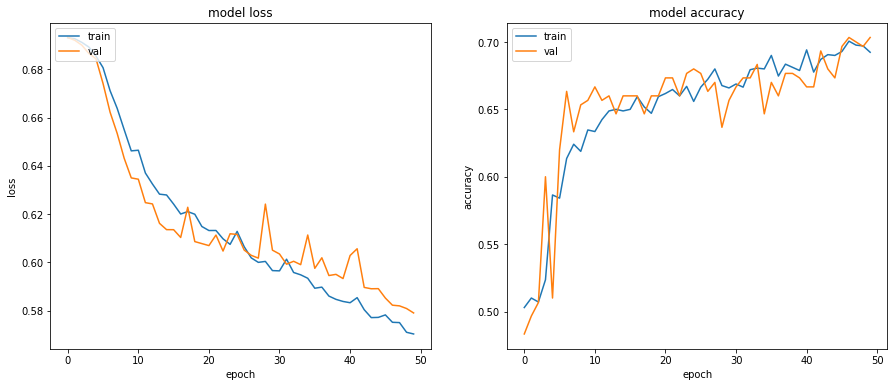

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que para este learning rate, el loss de validación baja continuamente, con la misma velocidad del loss del training (sin overfitting) alcanzando un accuracy de validación del 70.33%. 
Podría seguir bajando durante unas épocas mas.

Intentamos con otros valores de lr. 

In [ ]:
start = time.time()
reset_seed()
modelo_base_5e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-5, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693323, accuracy: 0.502941, val loss: 0.692723, val accuracy: 0.510000 -- epoch time: 8.51
Se mejoró el loss de inf a 0.692723274230957
1:  loss: 0.691839, accuracy: 0.523529, val loss: 0.687768, val accuracy: 0.506667 -- epoch time: 8.44
Se mejoró el loss de 0.692723274230957 a 0.6877679824829102
2:  loss: 0.681568, accuracy: 0.575294, val loss: 0.687311, val accuracy: 0.533333 -- epoch time: 8.56
Se mejoró el loss de 0.6877679824829102 a 0.6873109340667725
3:  loss: 0.671106, accuracy: 0.580588, val loss: 0.658529, val accuracy: 0.620000 -- epoch time: 8.70
Se mejoró el loss de 0.6873109340667725 a 0.6585286855697632
4:  loss: 0.651435, accuracy: 0.625294, val loss: 0.632234, val accuracy: 0.636667 -- epoch time: 8.52
Se mejoró el loss de 0.6585286855697632 a 0.6322343349456787
5:  loss: 0.634795, accuracy: 0.649412, val loss: 0.618261, val accuracy: 0.676667 -- epoch time: 8.43
Se mejoró el loss d

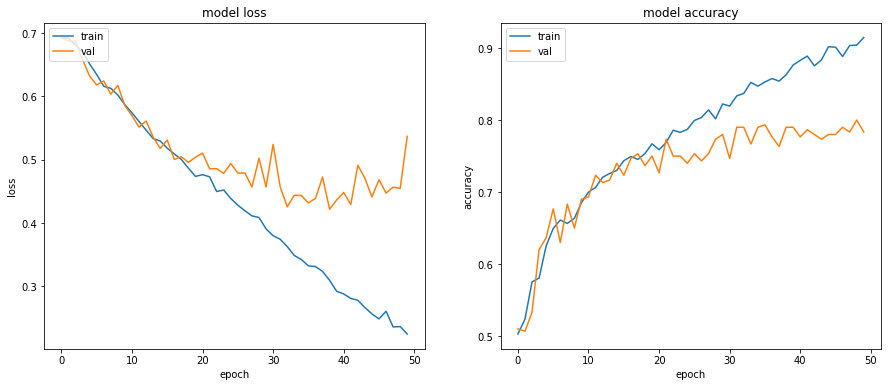

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que con un LR de 5e-5, el loss de validación baja a mayor velocidad que previamente, pero a partir de la época 21, comienza a presentarse una situación de overfitting.
El val loss al que se llega es de 0.42, con un accuracy de 79%, mejores métricas que con el learning rate anterior.

In [ ]:
start = time.time()
reset_seed()
modelo_base_1e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=30, val_split=0.15, early_stopping_acc_training = 0.95, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693787, accuracy: 0.504118, val loss: 0.692698, val accuracy: 0.623333 -- epoch time: 8.59
Se mejoró el loss de inf a 0.6926975846290588
1:  loss: 0.689751, accuracy: 0.555882, val loss: 0.679880, val accuracy: 0.596667 -- epoch time: 9.75
Se mejoró el loss de 0.6926975846290588 a 0.6798800826072693
2:  loss: 0.671781, accuracy: 0.583529, val loss: 0.679814, val accuracy: 0.533333 -- epoch time: 8.57
Se mejoró el loss de 0.6798800826072693 a 0.6798141598701477
3:  loss: 0.665856, accuracy: 0.595294, val loss: 0.659960, val accuracy: 0.596667 -- epoch time: 8.59
Se mejoró el loss de 0.6798141598701477 a 0.6599599123001099
4:  loss: 0.646689, accuracy: 0.623529, val loss: 0.635000, val accuracy: 0.640000 -- epoch time: 8.65
Se mejoró el loss de 0.6599599123001099 a 0.6349995732307434
5:  loss: 0.629769, accuracy: 0.653529, val loss: 0.626104, val accuracy: 0.636667 -- epoch time: 9.17
Se mejoró el loss

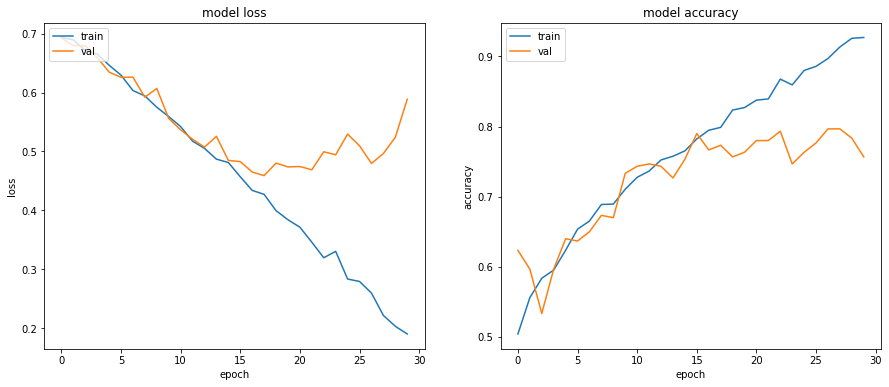

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)


Con un LR de 1e-4 se activa el **early stopping** para evitar el overfitting en la época 18, logrando resultados ligeramente peores que con un LR de 5e-5, pues en validación el loss llega a 0.459 (0.4218 antes) con un accuracy de 77.33% (79% antes).

En este punto es necesario tomar ciertas decisiones con respecto a los criterios de escogencia del mejor modelo:
- Podemos escoger el mejor modelo en cuanto al menor loss de validación alcanzado. Esta situación corresponde al modelo con LR de 5e-5 en la época 39, con un loss de 0.4218 aunque manchado de overfitting
- Podemos buscar un compromiso entre evitar overfitting y calidad de la predicción, sacrificando un poco el loss por una mayor estabilidad. Esta situación corresponde al modelo con LR de 1e-4 en la época 18.

Lo ideal es que los dos criterios ocurran para los mismos hiper-parámetros en la misma época, pero no siempre va a ser así, aunque se puede tratar de tener los dos criterios en cuenta al tiempo.

En esta caso, vamos a escoger el modelo que satisface la segunda característica.  No es necesario reentrenarlo pues el mejor modelo fue retornado por el método de entrenamiento



In [ ]:
modelo_base = modelo_base_1e4

Evaluamos entonces el dataset de test con el modelo escogido.

In [ ]:
test_loss, test_acc = eval_model(modelo_base, test_data_loader_small)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_base, "cats_and_dogs_small.pth")

El loss de test es 0.5502729597091675, y el accuracy de test es de 0.736. 


Vemos que el accuracy sobre el test set es de 73.6\%, relativamente cercano al 77.33\% estimado sobre el validation set, y no tan lejos del 79.88% del training set.

## Parte 5. Dataset reducido -- modelo con Dropout y batch normalization

### Dropout

Hay varias heramientas para combatir el **overfitting**, entre ellas, la regularización usando capas de tipo ```nn.Dropout```.
Estas capas se pueden agregar antes de las capas ```nn.Linear```, y tienen como labor apagar (poner en ceros), **solo durante el entrenamiento** una proporción de las entradas, con el objetivo de incentivar la no dependencia de algunas neuronas en particular, creando múltiples caminos en la red que permitan la identificaciones de patrones de mapeo entre inputs y outputs del modelo, reduciendo así el overfitting. 
Si es establece una tasa de 0.5 de drouput, el 50% de las entradas de una capa ```nn.Dropout``` se ponen en cero durante el entrenamiento, dejando pasar las demás con sus valores reescalados, de tal manera que la suma de todos los inputs quede estable.

Esta capa (asi como otras como la ```nn.BatchNormalization```) presentan un comportamiento diferente para el **entrenamiento** del modelo, al requerido durante el uso del modelo para **inferencia**. Es necesario indicarle a PyTorch el tipo de uso que se está dando al modelo, llamando a los métodos ```train()``` y ```eval```, para entrenamiento de los parámetros, y evaluación del dataset de validación (o test), respectivamente.

In [ ]:
class BinaryImageClassifierBase_Dropout(nn.Module):
    def __init__(self):
        super().__init__()    

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.dropout1 = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)

        self.dropout2 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        logits = self.linear2(x)
        probas = torch.sigmoid(logits)

        return probas

In [ ]:
modelo_base_dropout = BinaryImageClassifierBase_Dropout()
modelo_base_dropout.to(DEVICE)

BinaryImageClassifierBase_Dropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6272, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
summary(modelo_base_dropout, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
           Dropout-9            [-1, 128, 7, 7]               0
          Flatten-10                 [-1, 6272]               0
           Linear-11                  [-1, 512]       3,211,776
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 1]             513
Total params: 3,453,121
Trainable param

Vemos que las capas de dropout no tienen parámetros entrenables

El efecto esperado que tendrá el dropout en el entrenamiento es:
- las diferencias entre el training y el validation set en términos del loss no deberían crecer tan rápido, reduciendo el overfitting
- se puede llegar a demorar más épocas en llegar a un loss mínimo de validación. Vamos a aumentar el número de épocas.
- puede que el loss mínimo de validación sea mejor que sin dropout (o puede que no se logre).

Si bien existen capas ```nn.Dropout2d``` que se encargan de aleatoriamente apagar canales enteros (**spatial dropout**), que podrían ser utilizados antes de llamar a capas convolucionales, en este ejercicio solo consideramos capas ```nn.Dropout``` a aplicar antes de las capas lineales. Como ejercicio podrían agregar las capas 2d.

Buscamos el mejor learning rate, aplicamos early stopping sobre la paciencia del val loss.

In [ ]:
start = time.time()
reset_seed()
modelo_base_dropout_1e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_Dropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-5, epocas=70, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693098, accuracy: 0.501765, val loss: 0.693514, val accuracy: 0.483333 -- epoch time: 8.58
Se mejoró el loss de inf a 0.6935136914253235
1:  loss: 0.693085, accuracy: 0.502941, val loss: 0.693062, val accuracy: 0.483333 -- epoch time: 8.50
Se mejoró el loss de 0.6935136914253235 a 0.6930617690086365
2:  loss: 0.692521, accuracy: 0.502941, val loss: 0.692644, val accuracy: 0.483333 -- epoch time: 8.60
Se mejoró el loss de 0.6930617690086365 a 0.692644476890564
3:  loss: 0.692000, accuracy: 0.502353, val loss: 0.691843, val accuracy: 0.483333 -- epoch time: 8.61
Se mejoró el loss de 0.692644476890564 a 0.6918425559997559
4:  loss: 0.691366, accuracy: 0.510588, val loss: 0.691460, val accuracy: 0.483333 -- epoch time: 9.73
Se mejoró el loss de 0.6918425559997559 a 0.6914597749710083
5:  loss: 0.689313, accuracy: 0.518824, val loss: 0.687529, val accuracy: 0.523333 -- epoch time: 8.73
Se mejoró el loss d

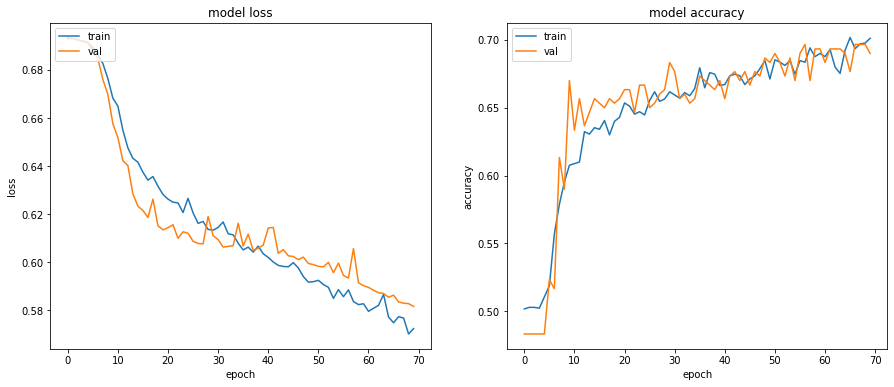

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que el overfitting está bastante controlado, aunque se demora muchas épocas en reducirse el loss. Intentamos con un LR mayor.

In [ ]:
start = time.time()
reset_seed()
modelo_base_dropout_5e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_Dropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-5, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693302, accuracy: 0.503529, val loss: 0.692635, val accuracy: 0.483333 -- epoch time: 8.68
Se mejoró el loss de inf a 0.6926354765892029
1:  loss: 0.693252, accuracy: 0.508235, val loss: 0.690714, val accuracy: 0.626667 -- epoch time: 8.68
Se mejoró el loss de 0.6926354765892029 a 0.6907142996788025
2:  loss: 0.688629, accuracy: 0.545294, val loss: 0.680132, val accuracy: 0.556667 -- epoch time: 8.58
Se mejoró el loss de 0.6907142996788025 a 0.6801316738128662
3:  loss: 0.679061, accuracy: 0.568824, val loss: 0.665777, val accuracy: 0.603333 -- epoch time: 8.55
Se mejoró el loss de 0.6801316738128662 a 0.6657766699790955
4:  loss: 0.662156, accuracy: 0.615294, val loss: 0.636439, val accuracy: 0.653333 -- epoch time: 8.59
Se mejoró el loss de 0.6657766699790955 a 0.6364393830299377
5:  loss: 0.643757, accuracy: 0.638824, val loss: 0.619218, val accuracy: 0.670000 -- epoch time: 9.63
Se mejoró el loss

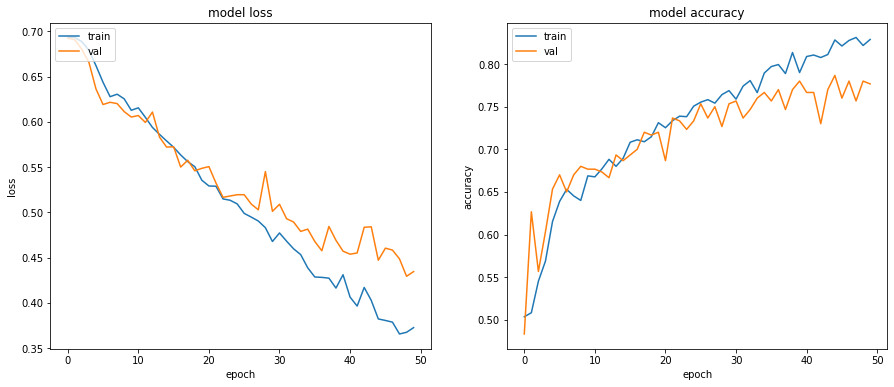

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que después de la época 25 comenzamos a apreciar un overfitting, aunque se sigue mejorando el loss de validación.

In [ ]:
start = time.time()
reset_seed()
modelo_base_dropout_1e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_Dropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693706, accuracy: 0.505294, val loss: 0.692491, val accuracy: 0.523333 -- epoch time: 11.30
Se mejoró el loss de inf a 0.692490816116333
1:  loss: 0.692627, accuracy: 0.515294, val loss: 0.688823, val accuracy: 0.520000 -- epoch time: 9.39
Se mejoró el loss de 0.692490816116333 a 0.6888230443000793
2:  loss: 0.680413, accuracy: 0.574706, val loss: 0.682720, val accuracy: 0.533333 -- epoch time: 8.69
Se mejoró el loss de 0.6888230443000793 a 0.6827200651168823
3:  loss: 0.672552, accuracy: 0.584706, val loss: 0.655345, val accuracy: 0.633333 -- epoch time: 8.60
Se mejoró el loss de 0.6827200651168823 a 0.6553447842597961
4:  loss: 0.654120, accuracy: 0.623529, val loss: 0.632806, val accuracy: 0.666667 -- epoch time: 8.56
Se mejoró el loss de 0.6553447842597961 a 0.6328062415122986
5:  loss: 0.640761, accuracy: 0.645882, val loss: 0.621226, val accuracy: 0.673333 -- epoch time: 8.57
Se mejoró el loss 

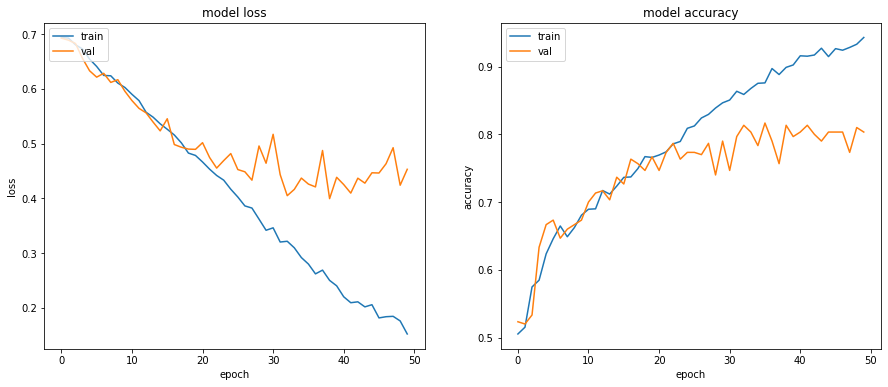

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que si bien el modelo sigue reduciendo el nivel de loss de validación después de la época 23, esta disminución se hace a una tasa mucho menor que la del loss de training, cayendo en overfitting.
Nos interesaría parar en la época 23, en donde no hay overfitting, y llegamos a un loss de 0.4416/0.4551, con accuracies de 78.59%/78.67%.

In [ ]:
start = time.time()
reset_seed()
modelo_base_dropout_5e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_Dropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-4, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.694015, accuracy: 0.515882, val loss: 0.692567, val accuracy: 0.516667 -- epoch time: 8.65
Se mejoró el loss de inf a 0.6925667524337769
1:  loss: 0.692288, accuracy: 0.536471, val loss: 0.684180, val accuracy: 0.576667 -- epoch time: 9.68
Se mejoró el loss de 0.6925667524337769 a 0.6841798424720764
2:  loss: 0.680797, accuracy: 0.580588, val loss: 0.674254, val accuracy: 0.570000 -- epoch time: 8.70
Se mejoró el loss de 0.6841798424720764 a 0.674253523349762
3:  loss: 0.671059, accuracy: 0.600588, val loss: 0.671657, val accuracy: 0.586667 -- epoch time: 8.61
Se mejoró el loss de 0.674253523349762 a 0.6716572046279907
4:  loss: 0.654209, accuracy: 0.627059, val loss: 0.636644, val accuracy: 0.680000 -- epoch time: 8.53
Se mejoró el loss de 0.6716572046279907 a 0.6366440653800964
5:  loss: 0.643880, accuracy: 0.619412, val loss: 0.640379, val accuracy: 0.616667 -- epoch time: 8.71
6:  loss: 0.624277,

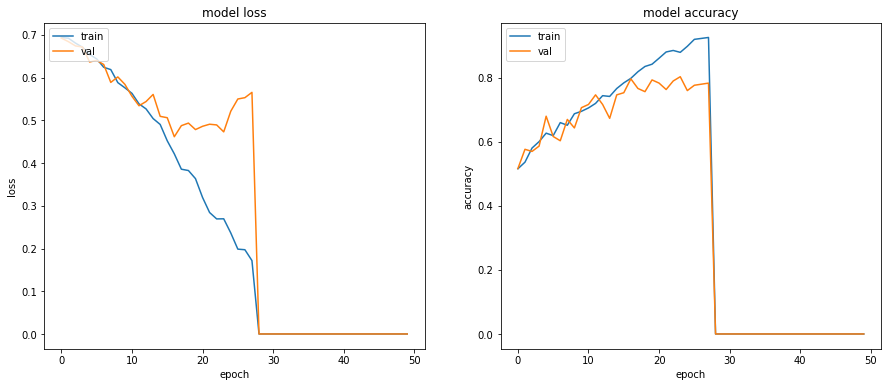

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

**Base**

**0.00010**(18):  loss: 0.4271/0.4590/0.5503, accuracy: 78.88%/77.33%/73.60%

**Dropout**

**0.00001**(70):  loss: 0.5723/0.5815,    accuracy: 70.12%/69.00%

**0.00005**(49):  loss: 0.3676/0.4294,    accuracy: 82.18%/78.00%

**0.00010**(39):  loss: 0.2499/0.3993,    accuracy: 89.88%/81.33%

**0.00010**(23):  loss: 0.4416/0.4551,    accuracy: 78.59%/78.67%  (paro explícito)

**0.00050**(17):  loss: 0.4216/0.4617,    accuracy: 78.82%/79.67%


Escogemos el modelo con LR 10e-4,  con 23 épocas.
Como el val loss continuó disminuyendo (aunque con overfitting), es necesario volver a entrenar este modelo, parándolo explícitamente en la época 23.

In [ ]:
start = time.time()
reset_seed()
modelo_base_dropout_1e4_23, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_Dropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=23, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.693706, accuracy: 0.505294, val loss: 0.692491, val accuracy: 0.523333 -- epoch time: 9.88
Se mejoró el loss de inf a 0.692490816116333
1:  loss: 0.692627, accuracy: 0.515294, val loss: 0.688823, val accuracy: 0.520000 -- epoch time: 12.04
Se mejoró el loss de 0.692490816116333 a 0.6888230443000793
2:  loss: 0.680413, accuracy: 0.574706, val loss: 0.682720, val accuracy: 0.533333 -- epoch time: 10.33
Se mejoró el loss de 0.6888230443000793 a 0.6827200651168823
3:  loss: 0.672552, accuracy: 0.584706, val loss: 0.655345, val accuracy: 0.633333 -- epoch time: 8.54
Se mejoró el loss de 0.6827200651168823 a 0.6553447842597961
4:  loss: 0.654120, accuracy: 0.623529, val loss: 0.632806, val accuracy: 0.666667 -- epoch time: 8.57
Se mejoró el loss de 0.6553447842597961 a 0.6328062415122986
5:  loss: 0.640761, accuracy: 0.645882, val loss: 0.621226, val accuracy: 0.673333 -- epoch time: 8.52
Se mejoró el loss

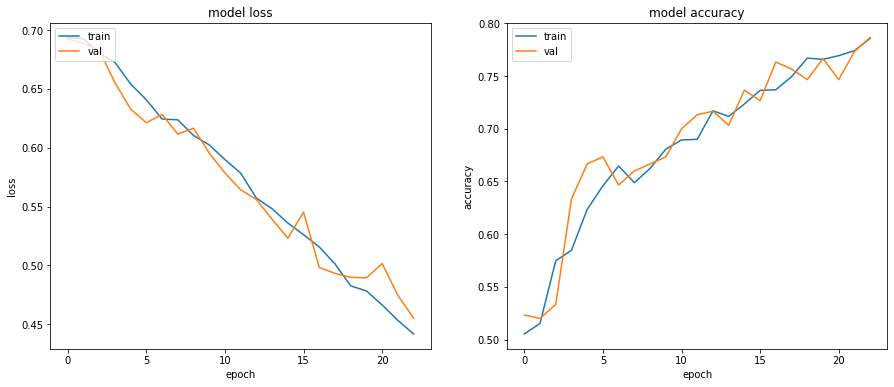

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
modelo_base_dropout = modelo_base_dropout_1e4_23

Evaluamos entonces el dataset de test con el modelo escogido.

In [ ]:
test_loss, test_acc = eval_model(modelo_base_dropout, test_data_loader_small)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_base_dropout, "cats_and_dogs_small_dropout.pth")

El loss de test es 0.5274034080505371, y el accuracy de test es de 0.725. 


Vemos que el loss del test set se bajó a 0.5274, reduciendo además el overfitting con respecto al mejor modelo precedente (sin dropout), aunque con un accuracy de test del 72.5%.

### Batch normalization

Veamos ahora el efecto que habría tenido la técnica de **Batch normalisation**, que está disponible en PyTorch para tensores 1D y 2D (capas ```nn.BatchNorm1d``` y ```nn.BatchNorm2d```, respectivamente, indicando el número de neuronas de salida), y que tiene como propósito realizar un pretratamiento de estandarización de los inputs (a nivel del conjunto de datos de cada batch) **antes de una función de activación** dentro de una red neuronal.
Cada batch de instancias tiene entonces la misma contribución al proceso de entrenamiento, y permite amplificar el impacto de cada actualización, posiblemente reduciendo el tiempo de entrenamiento necesario, reduciendo la dependencia en la inicialización de los pesos, permitiendo el aumento del learning rate, y generando un efecto de regularización que puede combatir el overfitting.

Durante el entrenamiento, la salida de esta capa va a ser 
$$batchnorm = \gamma * \frac{(batch - mean(batch))} {sqrt(var(batch) + \epsilon)} + \beta$$ 
donde $\gamma$ y $\beta$ son dos factores que se aprenden a medida que se entrena y controlan el escalado y centrado de la estandarización (se pueden deshabilitar con "scale=False" y "center=False", respectivamente), $\epsilon$ es una constante que impide división por cero (se puede indicar como argumento).

Durante la evaluación o predicción, el modelo considera el promedio móvil y varianza móvil de los batches de entrenamiento, teniendo en cuenta un hiperparámetro **momentum**. Los valores de $movingMean$ y $movingVar$ se actualizan cada vez que se ejecuta la capa durante el entrenamiento, y se utilizan para estimar la salida con la fórmula anterior en lugar de $mean(batch)$ y $var(batch)$.
$$movingMean = movingMean * momentum + mean(batch)$$
$$movingVar = movingVar * momentum + sqrt(var(batch))$$

Además de los parámetros \gamma  y \beta, aprendidos durante el entrenamiento,  
la capa **Batch Normalization** tiene los siguientes hiper parámetros, entre otros:
- **momentum**: controla el decaimiento del promedio y varianza móviles. Por defecto es 0.99
- **epsilon**: $\epsilon$ se usa para asegurar estabilidad numérica durante la normalización del mini batch. por defecto es 0.001.
- **center**: permite especificar si se quiere corregir con el valor de $\beta$
- **scale**: permite especificar si se quiere corregir con el valor de $\gamma$
- inicializadores y regulizadores para los arrays $\beta$ y $\gamma$, por defecto son zeros y unos, respectivamente.

Vamos a crear capas de batch normalization previas a cada función de activación, utilizando los valores por defecto de sus hiper parámetros.

In [ ]:
class BinaryImageClassifierBase_BNorm(nn.Module):

    def __init__(self):
        super().__init__()    

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.conv2_bn = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.conv3_bn = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.conv4_bn = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)
        self.linear1_bn = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(self.conv1_bn(x))
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(self.linear1_bn(x))

        logits = self.linear2(x)
        probas = torch.sigmoid(logits)

        return probas

In [ ]:
modelo_base_bnorm = BinaryImageClassifierBase_BNorm()
modelo_base_bnorm.to(DEVICE)

BinaryImageClassifierBase_BNorm(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): Ma

In [ ]:
summary(modelo_base_bnorm, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
       BatchNorm2d-2         [-1, 32, 148, 148]              64
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
       BatchNorm2d-5           [-1, 64, 72, 72]             128
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
       BatchNorm2d-8          [-1, 128, 34, 34]             256
         MaxPool2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
      BatchNorm2d-11          [-1, 128, 15, 15]             256
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Flatten-13                 [-1, 6272]               0
           Linear-14                  [

Vemos que las capas de batch normalization tienen parámetros entrenables:
- para las capas 2d convolucionales: hay 2 por cada filtro, recordemos que se aplica la función de activación a los net inputs de cada filtro
- para las capas 1d: hay 1 parámetro por cada neurona densa; se aplica una función de activación a los net inputs de cada una.


El efecto esperado que tendrá el batch normalization en el entrenamiento es:
- se reduce el impacto de la escala de los gradientes. Siendo estos mas balanceados se reduce la posibilidad de su explosión o desvanecimiento.
- se puede propagar más rápidamente los gradientes a las primeras capas
- se supone que los datos están igualmente distribuidos en el training set y test set
- el modelo será menos sensible a la inicialización de los parámetros de las capas
- se podrá utilizar un learning rate mayor, con las capas pudiendo aprender de maneras mas independientes las unas de las otras

Tenemos entonces que buscar un nuevo learning rate.

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_5e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNorm(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-5, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.638605, accuracy: 0.648235, val loss: 0.563923, val accuracy: 0.716667 -- epoch time: 8.77
Se mejoró el loss de inf a 0.5639229416847229
1:  loss: 0.415409, accuracy: 0.839412, val loss: 0.502259, val accuracy: 0.746667 -- epoch time: 8.81
Se mejoró el loss de 0.5639229416847229 a 0.5022589564323425
2:  loss: 0.296388, accuracy: 0.912353, val loss: 0.566372, val accuracy: 0.690000 -- epoch time: 8.77
3:  loss: 0.222370, accuracy: 0.943529, val loss: 0.471087, val accuracy: 0.773333 -- epoch time: 9.89
Se mejoró el loss de 0.5022589564323425 a 0.4710868299007416
4:  loss: 0.161533, accuracy: 0.969412, val loss: 0.568219, val accuracy: 0.753333 -- epoch time: 9.74
----- Se sobrepasó el límite de accuracy del early stopping 0.95)
time: 46.16


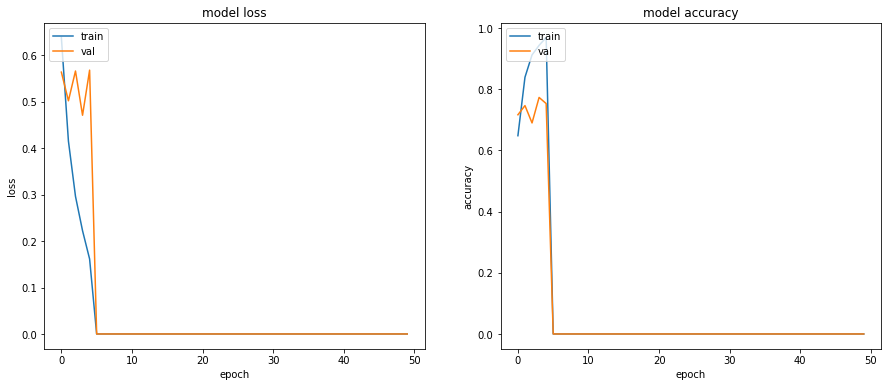

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que el LR es demasiado elevado, lo podemos reducir.

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_1e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNorm(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-5, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.650403, accuracy: 0.621765, val loss: 0.592229, val accuracy: 0.680000 -- epoch time: 11.58
Se mejoró el loss de inf a 0.592229425907135
1:  loss: 0.552869, accuracy: 0.724118, val loss: 0.565996, val accuracy: 0.700000 -- epoch time: 9.51
Se mejoró el loss de 0.592229425907135 a 0.5659955143928528
2:  loss: 0.489433, accuracy: 0.780588, val loss: 0.543011, val accuracy: 0.723333 -- epoch time: 13.67
Se mejoró el loss de 0.5659955143928528 a 0.5430113077163696
3:  loss: 0.446446, accuracy: 0.837647, val loss: 0.525118, val accuracy: 0.753333 -- epoch time: 9.86
Se mejoró el loss de 0.5430113077163696 a 0.5251176357269287
4:  loss: 0.405963, accuracy: 0.864706, val loss: 0.509134, val accuracy: 0.753333 -- epoch time: 11.84
Se mejoró el loss de 0.5251176357269287 a 0.5091341733932495
5:  loss: 0.363537, accuracy: 0.896471, val loss: 0.496226, val accuracy: 0.773333 -- epoch time: 8.90
Se mejoró el los

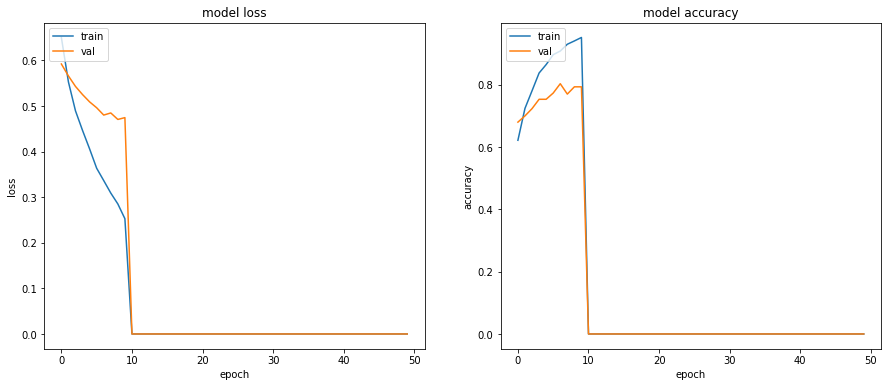

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_5e6, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNorm(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-6, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.664241, accuracy: 0.608235, val loss: 0.617296, val accuracy: 0.640000 -- epoch time: 8.84
Se mejoró el loss de inf a 0.6172961592674255
1:  loss: 0.596874, accuracy: 0.681765, val loss: 0.591774, val accuracy: 0.693333 -- epoch time: 8.83
Se mejoró el loss de 0.6172961592674255 a 0.5917741656303406
2:  loss: 0.553279, accuracy: 0.721765, val loss: 0.575070, val accuracy: 0.680000 -- epoch time: 10.74
Se mejoró el loss de 0.5917741656303406 a 0.5750704407691956
3:  loss: 0.524285, accuracy: 0.762353, val loss: 0.558597, val accuracy: 0.733333 -- epoch time: 8.76
Se mejoró el loss de 0.5750704407691956 a 0.5585971474647522
4:  loss: 0.495151, accuracy: 0.795294, val loss: 0.548488, val accuracy: 0.716667 -- epoch time: 8.82
Se mejoró el loss de 0.5585971474647522 a 0.5484877228736877
5:  loss: 0.464784, accuracy: 0.821176, val loss: 0.535643, val accuracy: 0.743333 -- epoch time: 8.87
Se mejoró el los

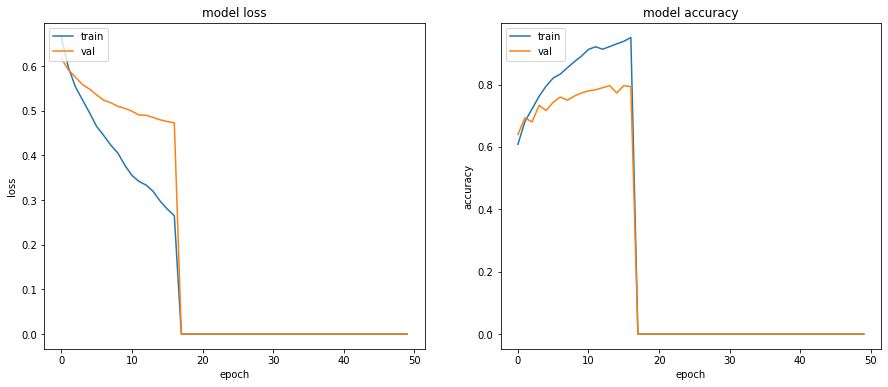

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_1e6, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNorm(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-6, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.694633, accuracy: 0.535882, val loss: 0.673198, val accuracy: 0.573333 -- epoch time: 10.63
Se mejoró el loss de inf a 0.6731978058815002
1:  loss: 0.662231, accuracy: 0.598235, val loss: 0.648431, val accuracy: 0.623333 -- epoch time: 8.97
Se mejoró el loss de 0.6731978058815002 a 0.6484310030937195
2:  loss: 0.642357, accuracy: 0.630000, val loss: 0.630732, val accuracy: 0.636667 -- epoch time: 10.30
Se mejoró el loss de 0.6484310030937195 a 0.6307315826416016
3:  loss: 0.629527, accuracy: 0.645882, val loss: 0.622630, val accuracy: 0.640000 -- epoch time: 9.08
Se mejoró el loss de 0.6307315826416016 a 0.622629702091217
4:  loss: 0.617916, accuracy: 0.672941, val loss: 0.617610, val accuracy: 0.646667 -- epoch time: 9.04
Se mejoró el loss de 0.622629702091217 a 0.6176102161407471
5:  loss: 0.606292, accuracy: 0.677059, val loss: 0.606982, val accuracy: 0.653333 -- epoch time: 9.06
Se mejoró el loss

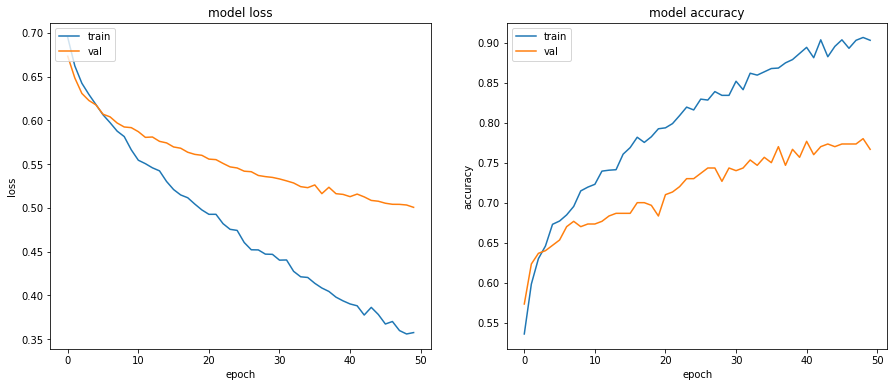

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

**Base**

**0.00010**(18):  loss: 0.4271/0.4590/0.5503, accuracy: 78.88%/77.33%/73.60%

**Dropout**

**0.00010**(23):  loss: 0.4416/0.4551/0.5274, accuracy: 78.59%/78.67%/72.50%  (paro explícito)

**BatchNorm**

**0.00005**(4):  loss: 0.2223/0.4711,    accuracy: 94.35%/77.33%

**0.00001**(8):  loss: 0.2852/0.4706,    accuracy: 94.06%/79.33%

**0.000005**(17):  loss: 0.2649/0.4731,    accuracy: 95.12%/79.33%

**0.000001**(50):  loss: 0.3576/0.5006,    accuracy: 90.29%/76.67%


Vemos que usar la técnica de batch normalization no nos aporta por si sola una mejora con respecto a lo previamente obtenido solo con la técnica de dropout.

### BatchNorm + Dropout

Veamos ahora con una combinación de las ds técnicas **Dropout** y **BatchNorm**.

In [41]:
class BinaryImageClassifierBase_BNormDropout(nn.Module):
    def __init__(self):
        super().__init__()    

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.conv2_bn = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.conv3_bn = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.conv4_bn = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)
        self.linear1_bn = nn.BatchNorm1d(512)
        
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=512, out_features=1)
 
    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(self.conv1_bn(x))
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.maxpool4(x)

        x = self.dropout1(x)
        x = self.flatten(x)

        x = self.linear1(x)
        x = F.relu(self.linear1_bn(x))
        x = self.dropout1(x)

        logits = self.linear2(x)
        probas = torch.sigmoid(logits)
        return probas

In [ ]:
summary(BinaryImageClassifierBase_BNormDropout().to(DEVICE), (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
       BatchNorm2d-2         [-1, 32, 148, 148]              64
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
       BatchNorm2d-5           [-1, 64, 72, 72]             128
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
       BatchNorm2d-8          [-1, 128, 34, 34]             256
         MaxPool2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
      BatchNorm2d-11          [-1, 128, 15, 15]             256
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Dropout-13            [-1, 128, 7, 7]               0
          Flatten-14                 [-

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_1e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-5, epocas=70, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.692477, accuracy: 0.577059, val loss: 0.626891, val accuracy: 0.643333 -- epoch time: 10.59
Se mejoró el loss de inf a 0.6268913745880127
1:  loss: 0.663113, accuracy: 0.614118, val loss: 0.603181, val accuracy: 0.670000 -- epoch time: 8.92
Se mejoró el loss de 0.6268913745880127 a 0.6031810641288757
2:  loss: 0.628846, accuracy: 0.645882, val loss: 0.591552, val accuracy: 0.673333 -- epoch time: 8.77
Se mejoró el loss de 0.6031810641288757 a 0.5915522575378418
3:  loss: 0.619251, accuracy: 0.644118, val loss: 0.582318, val accuracy: 0.696667 -- epoch time: 8.81
Se mejoró el loss de 0.5915522575378418 a 0.5823184251785278
4:  loss: 0.608489, accuracy: 0.664118, val loss: 0.574770, val accuracy: 0.686667 -- epoch time: 8.75
Se mejoró el loss de 0.5823184251785278 a 0.5747696161270142
5:  loss: 0.584576, accuracy: 0.692353, val loss: 0.567988, val accuracy: 0.716667 -- epoch time: 8.65
Se mejoró el los

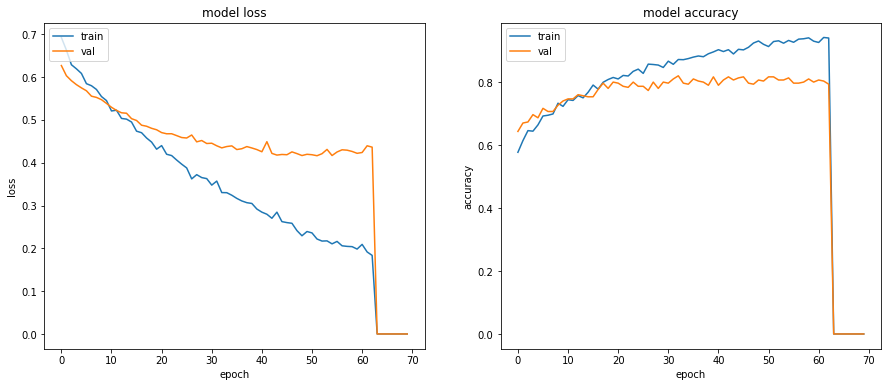

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que se desata la parada forzada por fuerte overfitting en la época 63.
Hasta la época 17 no hay oevrfitting.

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_5e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-5, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.666309, accuracy: 0.607647, val loss: 0.584986, val accuracy: 0.700000 -- epoch time: 8.70
Se mejoró el loss de inf a 0.5849859714508057
1:  loss: 0.603764, accuracy: 0.673529, val loss: 0.560165, val accuracy: 0.690000 -- epoch time: 8.71
Se mejoró el loss de 0.5849859714508057 a 0.5601646900177002
2:  loss: 0.538083, accuracy: 0.727059, val loss: 0.535202, val accuracy: 0.756667 -- epoch time: 8.82
Se mejoró el loss de 0.5601646900177002 a 0.5352016091346741
3:  loss: 0.518062, accuracy: 0.742353, val loss: 0.521571, val accuracy: 0.740000 -- epoch time: 8.87
Se mejoró el loss de 0.5352016091346741 a 0.5215705633163452
4:  loss: 0.483042, accuracy: 0.767059, val loss: 0.512861, val accuracy: 0.746667 -- epoch time: 8.71
Se mejoró el loss de 0.5215705633163452 a 0.5128605365753174
5:  loss: 0.429717, accuracy: 0.804706, val loss: 0.485030, val accuracy: 0.763333 -- epoch time: 8.75
Se mejoró el loss

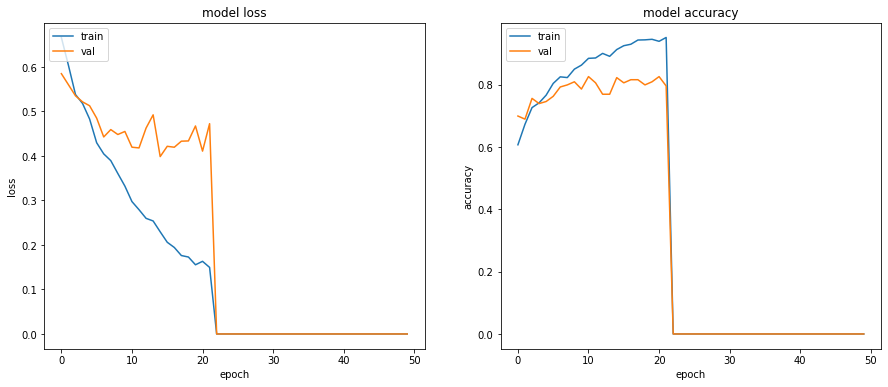

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Ocurre algo similar al run anterior. DEspués de la época 5 empieza un overfitting fuerte.

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_1e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=50, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.663132, accuracy: 0.617059, val loss: 0.566375, val accuracy: 0.700000 -- epoch time: 8.90
Se mejoró el loss de inf a 0.5663747191429138
1:  loss: 0.584540, accuracy: 0.688235, val loss: 0.550465, val accuracy: 0.716667 -- epoch time: 8.85
Se mejoró el loss de 0.5663747191429138 a 0.5504652261734009
2:  loss: 0.499757, accuracy: 0.755294, val loss: 0.545294, val accuracy: 0.720000 -- epoch time: 8.71
Se mejoró el loss de 0.5504652261734009 a 0.545293927192688
3:  loss: 0.464618, accuracy: 0.778235, val loss: 0.479539, val accuracy: 0.766667 -- epoch time: 8.76
Se mejoró el loss de 0.545293927192688 a 0.4795386791229248
4:  loss: 0.422658, accuracy: 0.811176, val loss: 0.541247, val accuracy: 0.730000 -- epoch time: 8.76
5:  loss: 0.357159, accuracy: 0.844118, val loss: 0.455769, val accuracy: 0.773333 -- epoch time: 8.73
Se mejoró el loss de 0.4795386791229248 a 0.45576900243759155
6:  loss: 0.331887

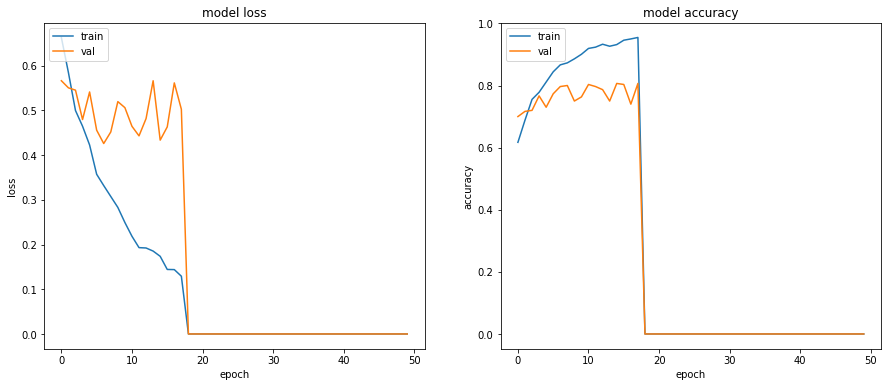

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

**Base**

**0.00010**(18):  loss: 0.4271/0.4590/0.5503, accuracy: 78.88%/77.33%/73.60%

**Dropout**

**0.00010**(23):  loss: 0.4416/0.4551/0.5274, accuracy: 78.59%/78.67%/72.50%  (paro explícito)

**BatchNorm**

**0.00001**(08):  loss: 0.2852/0.4706,    accuracy: 94.06%/79.33%

**Dropout+BatchNorm**

**0.00001**(63):  loss: 0.1835/0.4363,    accuracy: 94.00%/79.33%

**0.00001**(17):  loss: 0.4700/0.4876,    accuracy: 77.77%/77.67% (paro explícito)

**0.00005**(22):  loss: 0.1496/0.4726,    accuracy: 95.23%/79.67%

**0.00005**(05):  loss: 0.4830/0.5129,    accuracy: 76.71%/74.67% (paro explícito)

**0.00010**(18):  loss: 0.1291/0.5026,    accuracy: 95.47%/80.67%

**0.00010**(04):  loss: 0.4646/0.4795,    accuracy: 77.82%/78.67% (paro explícito)


Vemos que el modelo con LR 10e-4, con un paro explícito en la época 4 encontramos el mejor comportamento de la configuración Dropout + Batch Norm.
Vamos a evaluarlo sobre el test set.

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=4, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.663132, accuracy: 0.617059, val loss: 0.566375, val accuracy: 0.700000 -- epoch time: 9.74
Se mejoró el loss de inf a 0.5663747191429138
1:  loss: 0.584540, accuracy: 0.688235, val loss: 0.550465, val accuracy: 0.716667 -- epoch time: 8.85
Se mejoró el loss de 0.5663747191429138 a 0.5504652261734009
2:  loss: 0.499757, accuracy: 0.755294, val loss: 0.545294, val accuracy: 0.720000 -- epoch time: 8.66
Se mejoró el loss de 0.5504652261734009 a 0.545293927192688
3:  loss: 0.464618, accuracy: 0.778235, val loss: 0.479539, val accuracy: 0.766667 -- epoch time: 8.62
Se mejoró el loss de 0.545293927192688 a 0.4795386791229248
time: 36.14


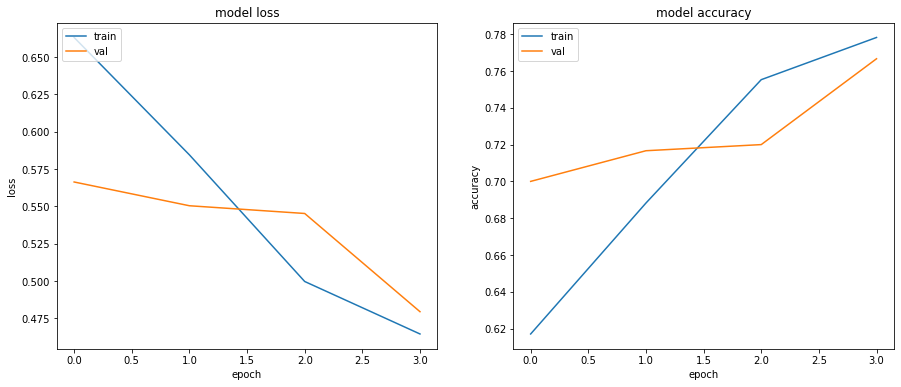

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
test_loss, test_acc = eval_model(modelo_base_bnorm_dropout, test_data_loader_small)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_base_bnorm_dropout, "cats_and_dogs_small_dropout_batchnorm.pth")

El loss de test es 0.521723984003067, y el accuracy de test es de 0.740. 


Vemos que el loss del test set se bajó a 0.5217 (casi lo mismo que con dropout)pero reduciendo aún mas el overfitting. Incidentalmente, el accuracy aumento a 74%.

## Parte 6. Dataset reducido - modelo con data augmentation

Escogemos el modelo que incluye dropout y batch normalization como la base para aplicar data augmentation.


La mejor manera de combatir el overfitting es obteniendo un dataset de aprendizaje mayor. 
Vamos a generar sintéticamente mas datos, algo que se puede hacer el caso de imágenes con una técnica llamada **data augmentation**.

Para mitigar el problema de overfitting en el caso de datasets con pocas imágenes, se pueden crear nuevas imágenes aplicando transformaciones gráficas a las imágenes disponibles, "aumentando" así el dataset de entrenamiento de manera artificial. 

Como lo vimos previamente en la sección de carga de datos, se pueden utilizar las clases que se encuentran en el paquete ```torchvision.transforms```, existen además funciones equivalentes que permiten crear las transformaciones sin necesidad de instanciación.

Vale la pena aclarar que estas operaciones se realizan solo sobre el dataset de entrenamiento, y que las transformaciones deben producir imágenes que corerspondan a las que se pueda encontrar el dataset de evaluación, de lo contrario, el modelo aprendería patrones lejanos a los de la distribución real de los datos.

Las transformaciones mas comunes a aplicar a todas las imágenes (ya sea una imagen o un batch de imágenes de train o de test) son:
* `Resize`: establece un tamaño de las imágenes
* `GrayScale`: modifica las imágenes entrantes de 3 canales de color a imágenes en escala de gris, ya sea con un solo canal o 3 canales iguales.

Adicionalmente, las transformacipnes mas comunes a aplicar a imágenes (ya sea una imagen o un batch de imágenes) son:


* `RandomHorizontalFlip`: crea una imagen espejo horizontal con una probabilidad dada por el argumento `p`.
* `RandomVerticalFlip`: crea una imagen espejo vertical con una probabilidad dada por el argumento `p`.
* `RandomAffineTransform`: permite generar varias transformaciones al tiempo, configuradas según ciertos argumentos:
    - `degrees`: se puede establecer un un intervalo (min, max) o un escalar `d`, caso en el que se supone un rango (`-d`, `+d`).
    - `translate`: tupla con los valores de fracción relativa máximos de traslación para cada eje. Por ejemplo, una tupla (`a`, `b`), indica que la imágen se puede trasladar hasta a\*ancho (hacia la izquierda o la derecha), y hasta a\*alto (hacia arriba o abajo). Por defecto no hay traslación.
    - `scale`: establece una tupla con los factores de escalamiento para realizar un zoom de la imagen. Por ejemplo, una tupla (`a`, `b`), indica que la imágen va a escalar escogiendo aleatoriamente un factor entre `a` y `b`.
    - `interpolation` permite establecer la estrategia a seguir para generar nuevos pixeles que puedan ser necesarios para las transformaciones de rotación, traslación o deformación; por defecto se copia el pixel más cercano.
    - `shear`: permite modificar la imagen estirándola horizontal y o verticalmente. Se recibe una tupla de 4 valores definiendo los intervalos horizontales y verticales sobre los cuales se hará el tiraje aleatorio para las deformaciones.

Es importante notar que existen otras transformaciones aleatorias atómicas que se pueden llegar a definir desde `RandomAffineTransform`. Particularmente tenemos `RandomRotation`, que rota las imágenes escogiendo un ángulo aleatorio; `RandomCrop`, que corta las imágenes escogiendo una región, creado un efecto de zoom, dado un tamaño aleatorio; y `RandomPerspective`, que modifica la imagen estirándola 


Vamos a crear un flujo de transformación que incluye una `RandomAffineTransform` seguido de una `RandomHorizontalFlip`. Como esperamos que las imágenes analizadas por el modelo no estén invertidas de arribe a abajo, no es necesario aplicar una transformación `RandomVerticalFlip`.

In [ ]:
DATA_AUG_TRANSFORMS = T.Compose([
    T.RandomAffine(degrees=(15), 
                   translate=(0.15, 0.15), 
                   scale=(1.15, 1.15), 
                   shear=(0., 0.08*IMG_SIZE, 0., 0.08*IMG_SIZE),
                   interpolation=T.InterpolationMode.NEAREST
                   ),
    T.RandomHorizontalFlip(p=0.5)
])

In [ ]:
imagenes, labels = next(iter(train_data_loader_small))

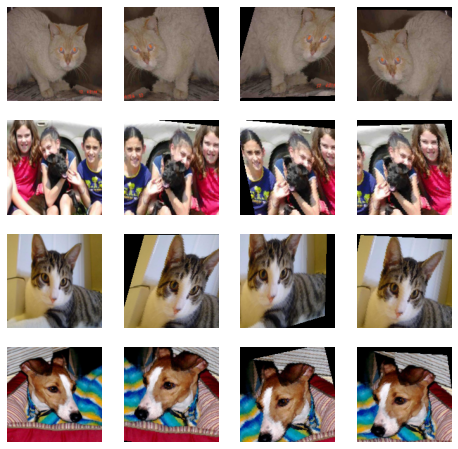

In [ ]:
reset_seed()

nrows = 4 # no puede ser mas que el tamaño del batch de imágenes
ncols = 4 # número de modificaciones (-1) con la misma imagen

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

for i, (img_original, label) in enumerate(zip(imagenes[:nrows], labels[:nrows])):
    sp = plt.subplot(nrows, ncols, i*ncols+1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img_canal = img_original.permute(1, 2, 0) # cambiar los canales
    plt.imshow(img_canal)

    # Creamos rotaciones de -30 a 30 grados
    #imagenes_transformadas = [T.RandomRotation(degrees=30)(img_original).permute(1, 2, 0) for i in range(3)]
    #imagenes_transformadas = [T.RandomCrop(size=np.floor(0.75*IMG_SIZE), pad_if_needed=True)(img_original).permute(1, 2, 0) for i in range(3)]
    #imagenes_transformadas = [T.RandomPerspective(distortion_scale=0.5, p=0.5)(img_original).permute(1, 2, 0) for i in range(3)]
    #imagenes_transformadas = [T.RandomAffine(degrees=30)(img_original).permute(1, 2, 0) for i in range(3)] # rotación
    #imagenes_transformadas = [T.RandomAffine(degrees=0, translate=(0.2, 0.2))(img_original).permute(1, 2, 0) for i in range(3)] # translación 
    #imagenes_transformadas = [T.RandomAffine(degrees=0, scale=(1.0, 1.5))(img_original).permute(1, 2, 0) for i in range(3)] #  zoom y crop
    #imagenes_transformadas = [T.RandomAffine(degrees=0, shear=(0., 0.2*IMG_SIZE, 0., 0.2*IMG_SIZE))(img_original).permute(1, 2, 0) for i in range(3)] #  deformación
    #imagenes_transformadas = [T.RandomAffine(degrees=(20), translate=(0.2, 0.2), scale=(1.2, 1.2), shear=(0., 0.10*IMG_SIZE, 0., 0.10*IMG_SIZE))(img_original).permute(1, 2, 0) for i in range(3)] #  de todo
    #imagenes_transformadas = [T.RandomHorizontalFlip(p=0.5)(img_original).permute(1, 2, 0) for i in range(3)]
    #imagenes_transformadas = [T.RandomVerticalFlip(p=0.5)(img_original).permute(1, 2, 0) for i in range(3)]
    imagenes_transformadas = [DATA_AUG_TRANSFORMS(img_original).permute(1, 2, 0) for i in range(3)] #  de todo
    
    for j, img_trans in enumerate(imagenes_transformadas): 
        sp = plt.subplot(nrows, ncols, i*ncols+2+j)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img_trans)

plt.show()


In [ ]:
DATA_AUG_TRANSFORMS = T.Compose([
    T.RandomAffine(degrees=(30), 
                   translate=(0.2, 0.2), 
                   scale=(1.10, 1.10), 
                   shear=(0., 0.2*IMG_SIZE, 0., 0.2*IMG_SIZE),
                   interpolation=T.InterpolationMode.NEAREST
                   ),
    T.RandomHorizontalFlip(p=0.5)
])

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_dataaug_1e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-5, epocas=100, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, transformaciones=DATA_AUG_TRANSFORMS, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.701591, accuracy: 0.533529, val loss: 0.644087, val accuracy: 0.646667 -- epoch time: 8.92
Se mejoró el loss de inf a 0.6440865993499756
1:  loss: 0.680661, accuracy: 0.574706, val loss: 0.624726, val accuracy: 0.643333 -- epoch time: 9.47
Se mejoró el loss de 0.6440865993499756 a 0.6247255802154541
2:  loss: 0.667743, accuracy: 0.589412, val loss: 0.625082, val accuracy: 0.683333 -- epoch time: 9.72
3:  loss: 0.668625, accuracy: 0.594118, val loss: 0.614421, val accuracy: 0.666667 -- epoch time: 8.90
Se mejoró el loss de 0.6247255802154541 a 0.6144210696220398
4:  loss: 0.669684, accuracy: 0.590588, val loss: 0.611196, val accuracy: 0.670000 -- epoch time: 8.86
Se mejoró el loss de 0.6144210696220398 a 0.6111955046653748
5:  loss: 0.654656, accuracy: 0.612353, val loss: 0.605117, val accuracy: 0.670000 -- epoch time: 8.94
Se mejoró el loss de 0.6111955046653748 a 0.6051168441772461
6:  loss: 0.66438

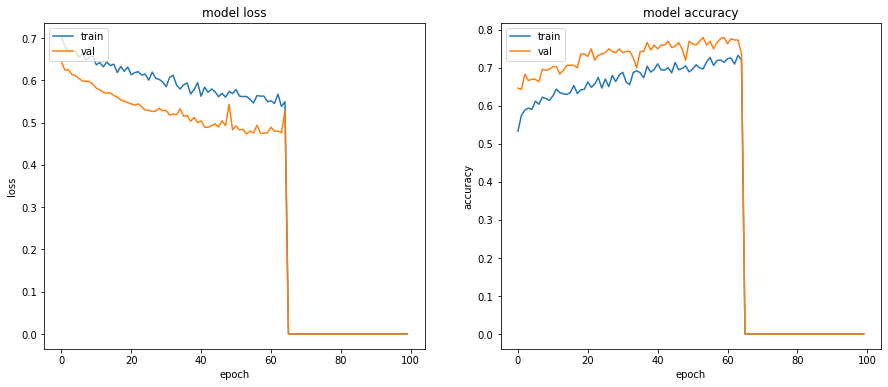

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Podemos ver que con el data augmentation y la creación de instancias modificadas el problema del overfitting se ha arreglado con una evolución del loss de validación reduciéndose más rápidamente que el loss del training. Alcanzamos con un LR muy bajo de 5e-5 un nivel de loss en validación inferior a los modelos previos (0.4732) con un accuracy del 78%.
La velocidad de reducción del loss no es mu alta, por lo que vamos a intentar aumentando el LR.

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_dataaug_5e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-5, epocas=100, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, transformaciones=DATA_AUG_TRANSFORMS, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.686520, accuracy: 0.581176, val loss: 0.612343, val accuracy: 0.663333 -- epoch time: 8.84
Se mejoró el loss de inf a 0.6123427748680115
1:  loss: 0.653427, accuracy: 0.624118, val loss: 0.582377, val accuracy: 0.686667 -- epoch time: 8.82
Se mejoró el loss de 0.6123427748680115 a 0.5823767185211182
2:  loss: 0.656350, accuracy: 0.608235, val loss: 0.601644, val accuracy: 0.676667 -- epoch time: 8.82
3:  loss: 0.650712, accuracy: 0.620000, val loss: 0.580702, val accuracy: 0.686667 -- epoch time: 8.85
Se mejoró el loss de 0.5823767185211182 a 0.5807019472122192
4:  loss: 0.647371, accuracy: 0.631765, val loss: 0.570602, val accuracy: 0.703333 -- epoch time: 9.90
Se mejoró el loss de 0.5807019472122192 a 0.5706015229225159
5:  loss: 0.622456, accuracy: 0.647647, val loss: 0.560937, val accuracy: 0.730000 -- epoch time: 8.87
Se mejoró el loss de 0.5706015229225159 a 0.5609365701675415
6:  loss: 0.63565

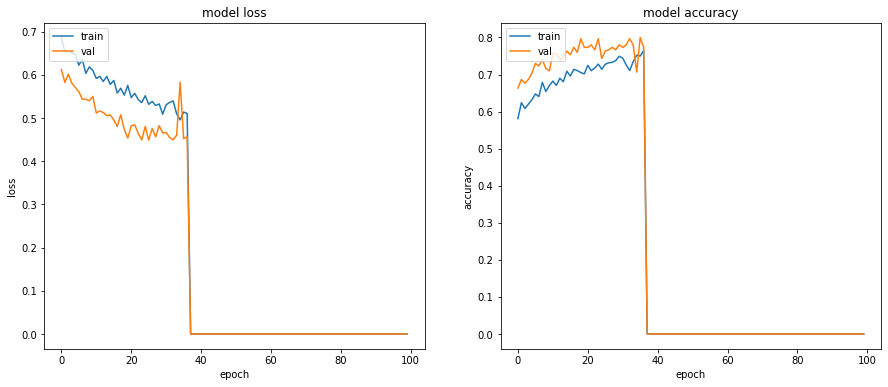

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_dataaug_1e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=100, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, transformaciones=DATA_AUG_TRANSFORMS, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.690383, accuracy: 0.579412, val loss: 0.602223, val accuracy: 0.680000 -- epoch time: 8.91
Se mejoró el loss de inf a 0.6022225022315979
1:  loss: 0.660901, accuracy: 0.615294, val loss: 0.566002, val accuracy: 0.716667 -- epoch time: 8.86
Se mejoró el loss de 0.6022225022315979 a 0.5660020112991333
2:  loss: 0.669430, accuracy: 0.602941, val loss: 0.585113, val accuracy: 0.693333 -- epoch time: 8.98
3:  loss: 0.642840, accuracy: 0.637059, val loss: 0.557541, val accuracy: 0.716667 -- epoch time: 9.84
Se mejoró el loss de 0.5660020112991333 a 0.5575411319732666
4:  loss: 0.635217, accuracy: 0.658824, val loss: 0.539566, val accuracy: 0.726667 -- epoch time: 8.84
Se mejoró el loss de 0.5575411319732666 a 0.5395659804344177
5:  loss: 0.620759, accuracy: 0.656471, val loss: 0.533838, val accuracy: 0.740000 -- epoch time: 8.86
Se mejoró el loss de 0.5395659804344177 a 0.5338376760482788
6:  loss: 0.63485

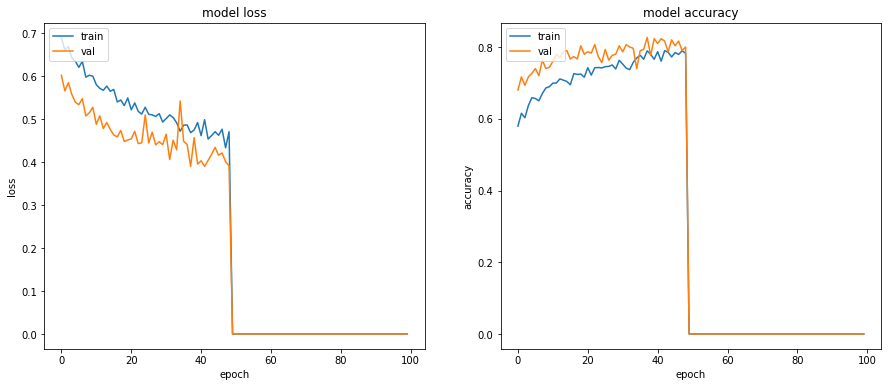

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_dataaug_5e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=5e-4, epocas=100, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, transformaciones=DATA_AUG_TRANSFORMS, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.723811, accuracy: 0.586471, val loss: 0.647371, val accuracy: 0.616667 -- epoch time: 8.87
Se mejoró el loss de inf a 0.647371232509613
1:  loss: 0.675623, accuracy: 0.618235, val loss: 0.583989, val accuracy: 0.713333 -- epoch time: 8.80
Se mejoró el loss de 0.647371232509613 a 0.5839892029762268
2:  loss: 0.648717, accuracy: 0.638235, val loss: 0.611471, val accuracy: 0.650000 -- epoch time: 8.81
3:  loss: 0.632892, accuracy: 0.641176, val loss: 0.583369, val accuracy: 0.693333 -- epoch time: 8.81
Se mejoró el loss de 0.5839892029762268 a 0.5833690762519836
4:  loss: 0.628626, accuracy: 0.647647, val loss: 0.557130, val accuracy: 0.700000 -- epoch time: 8.81
Se mejoró el loss de 0.5833690762519836 a 0.5571302175521851
5:  loss: 0.618879, accuracy: 0.664706, val loss: 0.546889, val accuracy: 0.720000 -- epoch time: 8.83
Se mejoró el loss de 0.5571302175521851 a 0.546889066696167
6:  loss: 0.622699, 

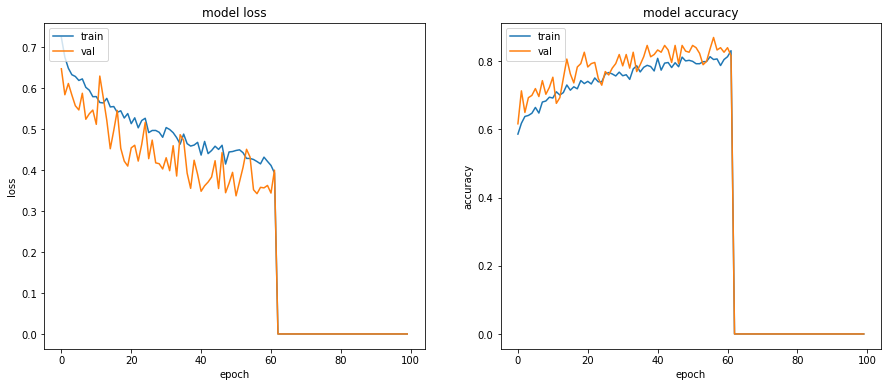

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
start = time.time()
reset_seed()
modelo_base_bnorm_dropout_dataaug_1e3, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-3, epocas=100, val_split=0.15, early_stopping_acc_training = 0.95, early_stopping_loss_val_patience=10, transformaciones=DATA_AUG_TRANSFORMS, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.729817, accuracy: 0.555882, val loss: 0.647243, val accuracy: 0.636667 -- epoch time: 9.17
Se mejoró el loss de inf a 0.6472427845001221
1:  loss: 0.671276, accuracy: 0.594118, val loss: 0.664422, val accuracy: 0.620000 -- epoch time: 9.03
2:  loss: 0.662105, accuracy: 0.621765, val loss: 0.626806, val accuracy: 0.623333 -- epoch time: 9.08
Se mejoró el loss de 0.6472427845001221 a 0.62680584192276
3:  loss: 0.647435, accuracy: 0.615294, val loss: 0.605999, val accuracy: 0.646667 -- epoch time: 9.01
Se mejoró el loss de 0.62680584192276 a 0.6059991121292114
4:  loss: 0.644729, accuracy: 0.632941, val loss: 0.574951, val accuracy: 0.666667 -- epoch time: 9.06
Se mejoró el loss de 0.6059991121292114 a 0.5749506950378418
5:  loss: 0.634461, accuracy: 0.654118, val loss: 0.554368, val accuracy: 0.703333 -- epoch time: 9.13
Se mejoró el loss de 0.5749506950378418 a 0.5543678998947144
6:  loss: 0.635177, a

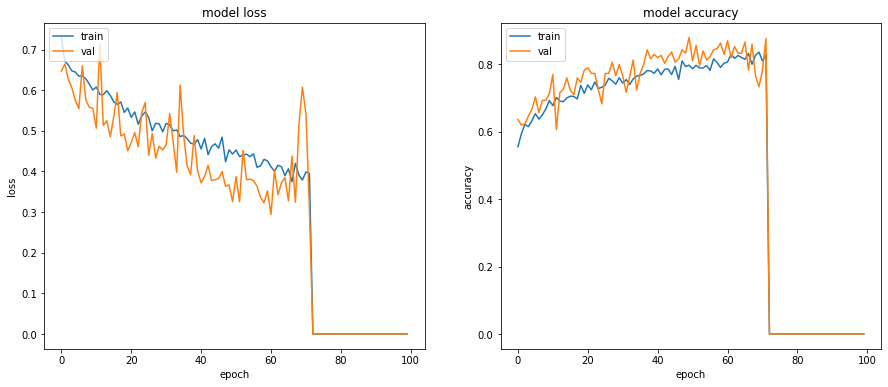

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que con un LR de 0.001, después de 61 épocas, comenzamos a overfittear, por lo que se desata el eary stopping.

**Base**

**0.00010**(18):  loss: 0.4271/0.4590/0.5503, accuracy: 78.88%/77.33%/73.60%

**Dropout**

**0.00010**(23):  loss: 0.4416/0.4551/0.5274, accuracy: 78.59%/78.67%/72.50%  (paro explícito)

**BatchNorm**

**0.00001**(08):  loss: 0.2852/0.4706,    accuracy: 94.06%/79.33%

**Dropout+BatchNorm**

**0.00010**(04):  loss: 0.4646/0.4795/0.5217,    accuracy: 77.82%/78.67%/74.00% (paro explícito)

**Dropout+BatchNorm+DataAugm**

**0.00001**(54):  loss: 0.5260/0.4732,    accuracy: 69.71%/78.00% (early stopping)

**0.00005**(26):  loss: 0.5318/0.4488,    accuracy: 72.76%/76.33% (early stopping) 

**0.00010**(38):  loss: 0.4687/0.3900,    accuracy: 78.94%/82.67% (early stopping)

**0.00050**(51):  loss: 0.4480/0.3372,    accuracy: 80.00%/84.67% (early stopping)

**0.00100**(61):  loss: 0.4115/0.2940,    accuracy: 80.71%/87.00% (early stopping)

Es claro que con data augmentation estamos llegando al mejor modelo hasta ahora, logrando reducir el los de validación de 0.47 a 0.29. Vamos a evaluar este modelo con el test set.

In [ ]:
modelo_base_bnorm_dropout_dataaug = modelo_base_bnorm_dropout_dataaug_1e3

In [ ]:
test_loss, test_acc = eval_model(modelo_base_bnorm_dropout_dataaug, test_data_loader_small)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_base_bnorm_dropout_dataaug, "cats_and_dogs_small_dropout_batchnorm_dataaug.pth")

El loss de test es 0.3476037859916687, y el accuracy de test es de 0.847. 


Vemos que el loss del test set se bajó de 0.5217 a 0.3476, con un accuracy sobre el test set pasando de 74% a 84.7%. **Es notable la mejora que proporciona el data augmentation cuando se dispone de un dataset de imágenes reducido.**

## Parte 7 - Dataset completo - modelo con Dropout y batch normalization


Vamos a entrenar el modelo con dropout y batch norm sobre el dataset completo.
Vamos a poder ver la importancia de tener un dataset de entrenamiento suficientemente grande.
Cada época va a trabajar sobre el dataset extendido de 22500 imágenes.
Vamos a aumentar el accuracy máximo sobre el training set, ya que vamos a encontrar que si bien éste puede llegar a muy altos niveles, el loss sobre el validation set seguirá mejorando continuamente.

In [ ]:
train_data_completo = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=TRANSFORM_IMG)
test_data_completo = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=TRANSFORM_IMG)

In [ ]:
#import warnings
#warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

start = time.time()
reset_seed()
modelo_base_bnorm_dropout_completo_1e4, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassifierBase_BNormDropout(), train_data_completo,
    train_batch_size=BATCH_SIZE, learning_rate=1e-4, epocas=100, val_split=0.15, early_stopping_acc_training = 0.98, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 19122, num_validation_instances 3375
0:  loss: 0.543258, accuracy: 0.723878, val loss: 0.444391, val accuracy: 0.783704 -- epoch time: 107.36
Se mejoró el loss de inf a 0.4443914950247164
1:  loss: 0.430424, accuracy: 0.801276, val loss: 0.392810, val accuracy: 0.817778 -- epoch time: 97.02
Se mejoró el loss de 0.4443914950247164 a 0.39281041903849
2:  loss: 0.387731, accuracy: 0.824809, val loss: 0.342812, val accuracy: 0.853926 -- epoch time: 100.06
Se mejoró el loss de 0.39281041903849 a 0.3428121042781406
3:  loss: 0.358195, accuracy: 0.840550, val loss: 0.354687, val accuracy: 0.840296 -- epoch time: 99.16
4:  loss: 0.326839, accuracy: 0.857599, val loss: 0.421527, val accuracy: 0.812444 -- epoch time: 98.15
5:  loss: 0.297498, accuracy: 0.873287, val loss: 0.424328, val accuracy: 0.809778 -- epoch time: 98.93
6:  loss: 0.280966, accuracy: 0.881759, val loss: 0.266101, val accuracy: 0.887111 -- epoch time: 98.82
Se mejoró el loss de 0.342812

El dataset completo tiene 22500, mas de 10 veces el dataset reducido (2000) utilizado para entrenar los modelos anteriores. Consecuentemente, cada época se demora casi 100 segundos (9 anteriormente).
Vemos rápidamente que se alcanzan niveles de loss de validación mucho mejores que los previamente alcanzados, sin llegar a presentarse overfitting importante.

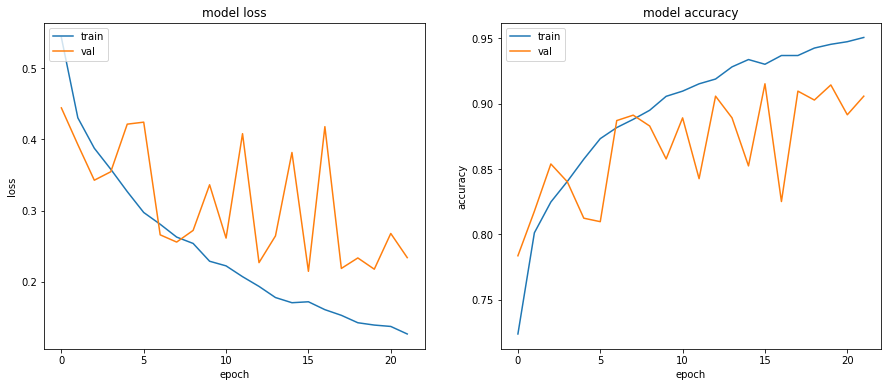

In [ ]:
plot_losses_and_accuracies(train_losses[:22], train_accuracies[:22], val_losses[:22], val_accuracies[:22])

In [ ]:
modelo_base_bnorm_dropout_completo = modelo_base_bnorm_dropout_completo_1e4

In [ ]:
test_loss, test_acc = eval_model(modelo_base_bnorm_dropout_completo, test_data_loader_small)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_base_bnorm_dropout_completo, "modelo_base_bnorm_dropout_completo.pth")

El loss de test es 0.08614252804219723, y el accuracy de test es de 0.973. 


En efecto, disponer de más datos de aprendizaje **reales** permite mejorar el entrenamiento del modelo.
Por un lado, vemos que la evolución del loss del set de train y del set de validación van de la mano (hasta la época 15 (16)).
Por otro lado, el valor del loss en el set de validación llega a un valor de alrededor 0.21 (inferior al 0.391 anterior), con un accuracy de alrededor 90% (muy superior al 85.7% del mejor modelo anterior (data augmentation)), con un loss y accuracy de 0.1 y 96.2% sobre el test set!


## Parte 8. Dataset reducido - transfer learning

Una de las características mas interesantes de los modelos convolucionales que trabajan con imágenes, es que se pueden reutilizar modelos pre entrenados con datasets suficientemente generales de mucho mayor tamaño, y aplicarlos a tareas diferentes, que no disponen de un gran volúmen de datos. 
La idea es reutilizar las características (los **features**) espaciales aprendidos sobre un dataset general y de gran tamaño, ya que son abstracciones suficientemente generales para poder ser útiles para otros problemas, así estos involucren otras clases diferentes a las de la tarea original.
La portabilidad de las características a diferentes tipos de problemas es la base del **transfer learning** de modelos conexionistas, que constituye una ventaja sobre modelos de ML tradicionales, y permite aplicar el deep learning a problemas que no dispongan de datasets suficientemente grandes.

Hay dos maneras de reutilizar modelos pre entrenados
- se pueden utilizar para hacer **feature extraction** sin tocar las capas convolucionales originales (lo que haremos en este punto), 
- se puede hacer **fine tuning** (lo que haremos en la siguiente parte) que toma el modelo importado como base de inicialización y remodifica algunas de sus capas convolucionales para adaptarlas a la tarea que queremos realizar (en este caso clasificación de perros y gatos)

El **feature extraction** consiste en utilizar las representaciones aprendidas por una red anterior como base de un nuevo modelo de clasificación.
Del modelo original se conservarán las capas convolucionales, que luego se conectarán con nuevas capas densas fully connected. 
Los datos de la nueva tarea son entonces pasados por las capas convolucionales originales, cuya salida es luego "aplastada" en un tensor 1D que sirve como inputs de una nueva red neuronal tradicional.

No se reutilizan las capas densas de los modelos originales, ya que son demasiado específicas a los problemas y clases originales con las que fueron entrenadas, sin contener información espacial de la ubicación de los conceptos aprendidos.
No son genéricas como lo son las capas convolucionales, que sirven como mapas de conceptos genéricos que podrían servir para todo tipo de problemas de computación visual.

El nivel de generalidad y reusabilidad de las representaciones extraídas por una capa convolucional específica depende de la profundidad de la misma. Las capas iniciales extraen conceptos locales mucho mas abstractos y altamente genéricos (lineas, esquinas, curvas), mientras que las capas finales extraen conceptos mas específicos (oreja de perro, nariz de gato). 
Es así como si la tarea de clasificación a la que se quiere transferir un modelo es muy diferente a la tarea original, puede ser mejor no utilizar todas las capas convolucionales, sino solo las primeras.
En este caso, como las clases de ImageNet comprendían últiples clases de perros y gatos, es provechoso reutilizar todas las capas convolucionales.

El subpaquete ```torchvision.models``` contiene definiciones de modelos pre entrenados para diferentes tareas (clasificación de imágenes, segmentación semántica, detección de imágenes, segmentación de instancias, clasificación de videos, etc.). 

Existen varios modelos disponibles gratuitamente para el transfer learning: VGG, Inception, ResNet, Inception-ResNet, Xception. Vamos a servirnos de `torchvision.models.vgg16` una Convnet con arquitectura **VGG16** que incluye capas de batch normalization, muy utilizada por su simple arquitectura, aunque un poco pesada (tamaño, número de parámetros).
Para una lista de los modelos disponibles directamente desde **torchvision** se encuentra aquí: https://pytorch.org/vision/stable/models.html

### Pre procesamiento de datos del modelo transferido

La arquitectura de los modelos transferidos se pueden instanciar y especificar los pesos a considerar.
**Torchvision** proporciona directamente un conjunto de pesos preentrenados par los modelos incluidos. Particularmente, vamos a utilizar los pesos `torchvision.models.vgg.VGG16_BN_Weights.IMAGENET1K_V1`, lo indicamos con el argumento `weights`. 
Estos pesos son el resultado del entrenamiento de una CNN **VGG16** para clasificación de imágenes en 1000 categorias, sobre un dataset llamado **ImageNet**, que incluye 1.4 millones de imágenes.
Entre las categorías se encuentran diferentes clases de animales, por lo que se estima que la transferencia a nuestro problem de clasificación de perros y gatos funcione bien.


In [51]:
pesos_vgg16_bn = models.vgg.VGG16_BN_Weights.IMAGENET1K_V1


Antes de usar un modelo pre entrenado, es necesario tener claras las transformaciones de pre procesamiento aque hay que realizar sobre las imágenes antes de pasarlas por el modelo en sí. Estas incluyen comúnmente operaciones de cambios de tamaño, recortes, y normalizaciones, entre otros, y se encuentran disponibles a través del atributo `transforms` de los pesos.

In [43]:
preprocesamientos = pesos_vgg16_bn.transforms()
preprocesamientos

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Veamos como queda una imágen pre procesada con este proceso

In [44]:
imagenes, labels = next(iter(test_data_loader_small))
imagenes.shape

torch.Size([16, 3, 150, 150])

torch.Size([3, 150, 150])


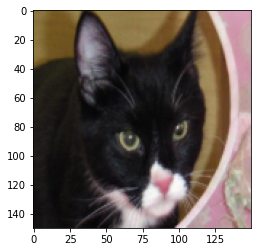

In [45]:
img = imagenes[0]
plt.imshow(img.permute(1, 2, 0))
print(img.shape)

In [46]:
img[0, 0:8, 0:8]

tensor([[0.5608, 0.5451, 0.5412, 0.5333, 0.5333, 0.5373, 0.5333, 0.5373],
        [0.5451, 0.5412, 0.5255, 0.5333, 0.5451, 0.5490, 0.5373, 0.5412],
        [0.5412, 0.5490, 0.5373, 0.5451, 0.5490, 0.5412, 0.5373, 0.5412],
        [0.5490, 0.5529, 0.5569, 0.5569, 0.5451, 0.5490, 0.5451, 0.5373],
        [0.5451, 0.5529, 0.5490, 0.5490, 0.5412, 0.5569, 0.5451, 0.5294],
        [0.5451, 0.5490, 0.5451, 0.5490, 0.5451, 0.5451, 0.5333, 0.5216],
        [0.5373, 0.5373, 0.5373, 0.5412, 0.5451, 0.5333, 0.5216, 0.5137],
        [0.5333, 0.5255, 0.5216, 0.5294, 0.5255, 0.5176, 0.5137, 0.5020]])

In [47]:
img_transformed = preprocesamientos(img)
img_transformed[0, 0:8, 0:8]

tensor([[-0.1034, -0.1352, -0.1650, -0.1935, -0.1825, -0.1663, -0.1529, -0.1495],
        [-0.0951, -0.1327, -0.1616, -0.1842, -0.1827, -0.1744, -0.1492, -0.1368],
        [-0.0809, -0.1244, -0.1504, -0.1637, -0.1624, -0.1562, -0.1363, -0.1256],
        [-0.0625, -0.1119, -0.1336, -0.1351, -0.1271, -0.1190, -0.1168, -0.1156],
        [-0.0500, -0.0950, -0.1169, -0.1220, -0.1184, -0.1135, -0.1083, -0.1079],
        [-0.0460, -0.0832, -0.1052, -0.1163, -0.1177, -0.1160, -0.1059, -0.1051],
        [-0.0811, -0.1007, -0.1187, -0.1356, -0.1377, -0.1360, -0.1260, -0.1252],
        [-0.1093, -0.1193, -0.1320, -0.1467, -0.1509, -0.1515, -0.1415, -0.1382]])

torch.Size([3, 224, 224])


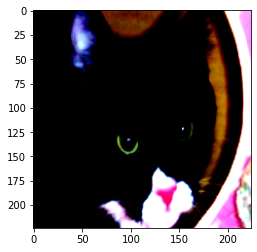

In [48]:
#torch_tensor = torch.from_numpy(img_transformed).long()
plt.imshow(img_transformed.permute(1, 2, 0))
print(img_transformed.shape)

Leemos de nuevo el dataset reducido, aplicándole las transformaciones incluidas en el modelo, para poder extraer las features.


In [49]:
train_data_small_transfer = torchvision.datasets.ImageFolder(root=TRAIN_SMALL_DIR, transform=preprocesamientos)
test_data_small_transfer = torchvision.datasets.ImageFolder(root=TEST_SMALL_DIR, transform=preprocesamientos)
train_data_loader_small_transfer = torch.utils.data.DataLoader(train_data_small_transfer, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_data_loader_small_transfer = torch.utils.data.DataLoader(test_data_small_transfer, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 

### Feature Extraction

Cargamos el modelo transferido y analizamos su arquitectura.

In [63]:
modelo_vgg16_bn = models.vgg16_bn(weights=pesos_vgg16_bn).to(DEVICE)
summary(modelo_vgg16_bn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
modelo_vgg16_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Vemos que la primera capa lineal se encuentra despues de una capa intermedia de tipo `AdaptiveAvgPool2D`, esta capa se encarga de realizar un pooling con promedios, pero en vez de definir el tamaño de la ventana y el stride, se define el tamaño del feature map deseado, de tal manera que automáticamente se calculan estos dos atributos.

Antes de la capa intermedia tenemos una capa de `MaxPooling2d`, que nos dará los features que reutilizaremos.
Interesante verificar que este modelo tiene 138 millones de parámetros a entrenar. Sin embargo, como queremos realizar **feature extraction**, no nos interesan las capas densas finales del modelo (responsables de mas de 123 millones de parámetros), nos quedamos con con las anteriores (con 14.7 millones)

Podemos obtener directamente los features del modelo utilizando el atributo `features` (parte del modelo secuencial). Vemos que se retorna un modelo secuencial que para en la última capa `MaxPool2d`.

In [ ]:
summary(modelo_vgg16_bn.features, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

Intentemos pasar un batch por el feature extraction

In [ ]:
imagenes, labels = next(iter(test_data_loader_small_transfer))
imagenes.shape

torch.Size([16, 3, 224, 224])

In [ ]:
start = time.time()
modelo_vgg16_bn.features.eval()
with torch.no_grad():
    features_extracted = modelo_vgg16_bn.features(imagenes.to(DEVICE))
end = time.time()
print(f"Tiempo de extracción de features de un batch de {BATCH_SIZE} imágenes: {(end-start):.2f} segundos")
features_extracted.shape

Tiempo de extracción de features de un batch de 16 imágenes: 0.21 segundos


torch.Size([16, 512, 7, 7])

El tensor final tiene instancias con tensores (512, 7, 7, 512), 512 feature maps ("imágenes") de 7x7, con las características extraídas de los tensores originales, que se conectan luego con la parte densa fully connected de la red encargada de hacer la clasificación.

Hay 2 maneras de proceder en este punto:
* Procesar el dataset de la tarea de destino (perros y gatos) pasándolo por la base convolucional, para luego grabar en disco el tensor final o conservar en memoria, que luego se puede cargar en una segunda etapa como los inputs de entrenamiento de una nueva red con la base fully connected. Esta solución es rápida y ahorradora en tiempo de ejecución (vemos que un solo batch se demora mas de 10 segundos en CPU, menos de 1 segundo en GPU), pues solo se utilizará la red convolucional una sola vez por cada imágen, la parte más consumidora de procesamiento, sin tener que repetirla por cada paso de entrenamiento. Pero esta técnica impide utilizar un eventual **data augmentation**, pues las imágenes de origen son siempre las mismas.
* Extender el submodelo convolucional (llamado **features**) de base importado, agregándole la subred fully connected, que serían las únicas capas que serían entrenadas. Esto permite el **data augmentation**, pero es mucho más costosa que la anterior.

Vamos a escoger la primera opción por simplicidad, y luego podríamos evaluar la segunda si necesario. Vamos a conservar en memoria los features extraidos.

In [ ]:
def extract_features (dataset, shuffle=False):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=2)
    
    # se crea un tensor vacío, que luego llenaremos
    features_extracted = torch.empty(size=(len(dataset.imgs), 512, 7, 7))
    labels_extracted = torch.empty(size=(len(dataset.imgs),))
    modelo_vgg16_bn.features.eval()
    with torch.no_grad():
        for i, (imagenes, labels) in enumerate(data_loader):
            # print(f"{i}: desde {i*BATCH_SIZE}, hasta {i*BATCH_SIZE + BATCH_SIZE}")
            # print(features_extracted[i,0])
            features = modelo_vgg16_bn.features(imagenes.to(DEVICE))
            features_extracted[i*BATCH_SIZE: i*BATCH_SIZE + BATCH_SIZE] = features
            labels_extracted[i*BATCH_SIZE: i*BATCH_SIZE + BATCH_SIZE] = labels.to(DEVICE)
            # print(features_extracted[i,0])
    return features_extracted, labels_extracted

El siguiente código en CPU toma bastante tiempo

In [ ]:
start = time.time()
train_features, train_labels = extract_features(train_data_small_transfer, shuffle=True)
end = time.time()
print(f"Tiempo de extracción de features de imágenes de training: {(end-start):.2f} segundos")

start = time.time()
test_features, test_labels = extract_features(test_data_small_transfer, shuffle=False)
end = time.time()
print(f"Tiempo de extracción de features de imágenes de test: {(end-start):.2f} segundos")

Tiempo de extracción de features de imágenes de training: 21.84 segundos
Tiempo de extracción de features de imágenes de test: 9.47 segundos


Ya tenemos en memoria los tensores con los features y labels extraidos

In [ ]:
print(f"train features: {train_features.shape}, labels: {train_labels.shape}")
print(f"train features: {test_features.shape}, labels: {test_labels.shape}")

train features: torch.Size([2000, 512, 7, 7]), labels: torch.Size([2000])
train features: torch.Size([1000, 512, 7, 7]), labels: torch.Size([1000])


Creamos ahora un clasificador con red neuronal sencilla únicamente con capas densas.

In [ ]:
class BinaryImageClassfierBase_FeatureExtraction(nn.Module):
    def __init__(self):
        super().__init__()    
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=512*7*7, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, features):
        x = self.flatten(features)
        x = self.linear1(x)
        x = F.relu(x)
        logits = self.linear2(x)
        probas = torch.sigmoid(logits)

        #return logits
        return probas

In [ ]:
modelo_feat_extract = BinaryImageClassfierBase_FeatureExtraction()
modelo_feat_extract.to(DEVICE)

BinaryImageClassfierBase_FeatureExtraction(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=25088, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
summary(modelo_feat_extract, (512, 7, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 25088]               0
            Linear-2                  [-1, 512]      12,845,568
            Linear-3                    [-1, 1]             513
Total params: 12,846,081
Trainable params: 12,846,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.20
Params size (MB): 49.00
Estimated Total Size (MB): 49.29
----------------------------------------------------------------


Tenemos un modelo con una sola capa escondida con 12.8 millones de parámetros, que vamos a entrenar a partir de un dataloader creado sobre los tensores obtenidos a partir del feature extraction.

In [ ]:
train_data_small_feature_extraction = torch.utils.data.TensorDataset(train_features, train_labels)
test_data_small_feature_extraction = torch.utils.data.TensorDataset(test_features, test_labels)
test_data_loader_small_feature_extraction = torch.utils.data.DataLoader(test_data_small_feature_extraction, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 

In [ ]:
start = time.time()
reset_seed()
modelo_feat_extract_1e5, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    BinaryImageClassfierBase_FeatureExtraction(), train_data_small_feature_extraction,
    train_batch_size=BATCH_SIZE, learning_rate=1e-5, epocas=30, val_split=0.15, early_stopping_acc_training = -1, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.290579, accuracy: 0.954706, val loss: 0.112847, val accuracy: 0.986667 -- epoch time: 1.50
Se mejoró el loss de inf a 0.11284682154655457
1:  loss: 0.074410, accuracy: 0.991176, val loss: 0.071636, val accuracy: 0.990000 -- epoch time: 1.49
Se mejoró el loss de 0.11284682154655457 a 0.07163649052381516
2:  loss: 0.043645, accuracy: 0.994118, val loss: 0.058795, val accuracy: 0.983333 -- epoch time: 1.49
Se mejoró el loss de 0.07163649052381516 a 0.058795493096113205
3:  loss: 0.029297, accuracy: 0.997059, val loss: 0.052012, val accuracy: 0.983333 -- epoch time: 1.47
Se mejoró el loss de 0.058795493096113205 a 0.05201185867190361
4:  loss: 0.020810, accuracy: 0.997647, val loss: 0.049507, val accuracy: 0.990000 -- epoch time: 1.47
Se mejoró el loss de 0.05201185867190361 a 0.049506787210702896
5:  loss: 0.015722, accuracy: 0.998824, val loss: 0.046072, val accuracy: 0.983333 -- epoch time: 1.48
Se me

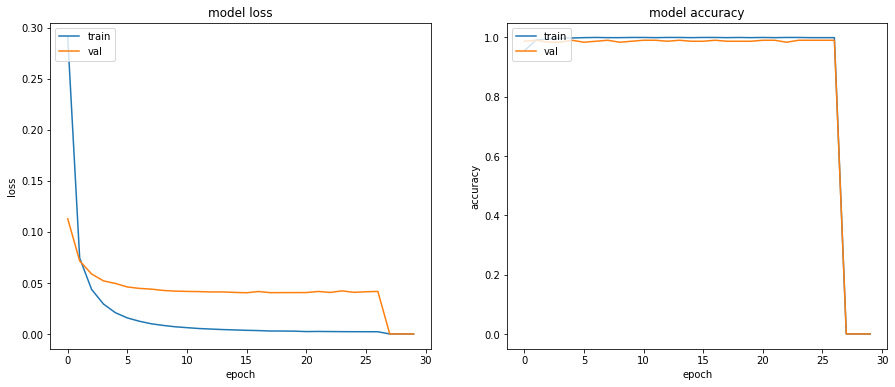

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
test_loss, test_acc = eval_model(modelo_feat_extract_1e5, test_data_loader_small_feature_extraction)
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_feat_extract_1e5, "cats_and_dogs_small_bnorm_tl_feat_extract.pth")

El loss de test es 0.022164601833210326, y el accuracy de test es de 0.994. 


**Reducido - Base**

**0.00010**(18):  loss: 0.4271/0.4590/0.5503, accuracy: 78.88%/77.33%/73.60%

**Dropout**

**0.00010**(23):  loss: 0.4416/0.4551/0.5274, accuracy: 78.59%/78.67%/72.50%  (paro explícito)

**BatchNorm**

**0.00001**(08):  loss: 0.2852/0.4706,    accuracy: 94.06%/79.33%

**Dropout+BatchNorm**

**0.00010**(04):  loss: 0.4646/0.4795/0.5217,    accuracy: 77.82%/78.67%/74.00% (paro explícito)

**Dropout+BatchNorm+DataAugm**

**0.00100**(61):  loss: 0.4115/0.2940/0.3476,    accuracy: 80.71%/87.00%/84.70% (early stopping)

**TLearning - Feature Extraction**

**0.00001**(16):  loss: 0.0036/0.0404/0.0222,    accuracy: 99.94%/98.67%/99.40% (early stopping)

**Completo - Base**

**0.00001**(16):  loss: 0.1721/0.2149/0.0861,    accuracy: 93.02%/91.53%/97.30% (early stopping)


Vemos que el modelo con transfer learning con feature extraction alcanza un nivel de loss muy inferior y de accuracy muy superior a los previamentes alcanzados, incluido el modelo entrenado sobre todas las imágenes disponibles.

### Fine Tuning

Normalmente con las métricas logradas con el modelo que utiliza transfer learning a partir de feature extraction sobre el dataset de perros y gatos, ya no sería necesario continuar buscando.
Sin embargo, por completitud, vamos a ilustrar el proceso de aplicar transfer learning con fine tuning a un modelo de clasificación.

La base del modelo de fine tuning va a ser el modelo preentrenado.
Lo primero que vamos a hacer es "congelar" el entrenamiento de todos los parámetros del submódulo `features`, seteando su atributo `requires_grad` a `False`, salvo por el último bloque convolucional. Este último bloque comienza en la capa con índice 40.

In [64]:
for i, module in enumerate(modelo_vgg16_bn.features.children()):
    if i<=39:
        for param in module.parameters():
            param.requires_grad = False        
    else:
        print(f"{i}: Capa {module}")
        for param in module.parameters():
            print(f"  Descongelar parámetro {param.shape}")

40: Capa Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  Descongelar parámetro torch.Size([512, 512, 3, 3])
  Descongelar parámetro torch.Size([512])
41: Capa BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  Descongelar parámetro torch.Size([512])
  Descongelar parámetro torch.Size([512])
42: Capa ReLU(inplace=True)
43: Capa MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Como segundo paso, necesitamos adaptar la cabeza de clasificación (submodulo `classifier`) a la nueva tarea. Creamos un submódulo mucho más simple (una sola capa escondida densa con 512 neuronas), similar a la previamente utilizada en el modelo de clasificación de feature extraction. No necesitamos aplanar los features, pues el modelo transferido se encarga de eso.

La salida de las redes previas en el método `forward` aplican una función de activación sigmoide para retornar probabilidades, por lo que aplicamos el loss `nn.BCELoss`.
Como estamos modificando la cabeza de clasificación tenemos dos opciones, que son completamente equivalentes:
- Seguir utilizando la función de pérdida `nn.BCELoss` que hemos usado hasta ahora, pero agregando como salida del modelo un módulo `nn.Sigmoid` que convierta los logits a probabilidades.
- No agregar un módulo final a la salida de la cabeza de clasificación, que retornará logits, y modificar la función de pérdida a `nn.BCEWithLogitsLoss`. 

Como en los ejemplos anteriores hemos utilizado la primera aproximación (la que se ve en el curso), en este caso vamos a ilustrar cómo sería el caso de aplicar la segunda opción, que es computacionalmente numéricamente más estable que la primera y por ende mas aconsejable.

In [65]:
logits = torch.randn(3, requires_grad=False)
labels = torch.empty(3).random_(2)
probas = nn.Sigmoid()(logits)
print(f"logits: {logits}")
print(f"probas: {probas}")
print(f"labels: {labels}")


output = nn.BCELoss()(probas, labels)
print("BCE", output)

output = nn.BCEWithLogitsLoss()(logits, labels)
print("BCE With Logits", output)

logits: tensor([ 1.1430,  1.0481, -0.3597])
probas: tensor([0.7582, 0.7404, 0.4110])
labels: tensor([1., 1., 0.])
BCE tensor(0.3689)
BCE With Logits tensor(0.3689)


In [66]:
classif_head = nn.Sequential(
	nn.Linear(in_features=512*7*7, out_features=512),
	nn.ReLU(),
	nn.Linear(in_features=512, out_features=1)
)

In [67]:
modelo_vgg16_bn.classifier = classif_head

In [68]:
modelo_vgg16_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Para verificar que solo se actualizaron los pesos en las capas descongeladas, vamos a imprimir algunos de los parámetros. 
Haremos un seguimiento de los pesos de la capa convolucional congelada de índice 37 y de la capa convolucional descongelada de índice 40.

In [69]:
print(f"capa congelada {modelo_vgg16_bn.features.get_parameter('37.weight').shape}")
print(modelo_vgg16_bn.features.get_parameter('37.weight')[0, 0])
print(f"capa descongelada {modelo_vgg16_bn.features.get_parameter('40.weight').shape}")
print(modelo_vgg16_bn.features.get_parameter('40.weight')[0, 0])

capa congelada torch.Size([512, 512, 3, 3])
tensor([[-0.0106, -0.0231, -0.0083],
        [-0.0096, -0.0031,  0.0060],
        [-0.0059,  0.0058,  0.0115]], device='cuda:0')
capa descongelada torch.Size([512, 512, 3, 3])
tensor([[ 4.8097e-03,  6.9162e-04,  9.9851e-04],
        [-6.2526e-03, -1.2559e-02, -4.9773e-03],
        [-7.5619e-07, -3.3279e-03,  6.1700e-03]], device='cuda:0',
       grad_fn=<SelectBackward0>)


Ya con el modelo listo, podemos disponernos a reentrenarlo. Solo se verán afectadas la cabeza de clasificación y el último bloque convolucional que no quedó "congelado".
Con CPU, una época toma 565 segundos (9.4 minutos).
Con GPU, una época toma 14 segundos (minutos).

In [70]:
start = time.time()
reset_seed()
modelo_vgg16_bn, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    modelo_vgg16_bn, train_data_small,
    train_batch_size=BATCH_SIZE, learning_rate=1e-5, epocas=30, loss_fn=nn.BCEWithLogitsLoss(), 
    val_split=0.15, early_stopping_acc_training = -1, early_stopping_loss_val_patience=10, verbose=True)
end = time.time()
print(f"time: {end-start:.2f}")

val_split: 0.15, num_training_instances 1700, num_validation_instances 300
0:  loss: 0.271511, accuracy: 0.915882, val loss: 0.128348, val accuracy: 0.943333 -- epoch time: 17.80
Se mejoró el loss de inf a 0.12834757566452026
1:  loss: 0.102408, accuracy: 0.960000, val loss: 0.105462, val accuracy: 0.953333 -- epoch time: 19.17
Se mejoró el loss de 0.12834757566452026 a 0.10546194016933441
2:  loss: 0.075386, accuracy: 0.975294, val loss: 0.095136, val accuracy: 0.966667 -- epoch time: 19.10
Se mejoró el loss de 0.10546194016933441 a 0.0951363816857338
3:  loss: 0.054654, accuracy: 0.981176, val loss: 0.092423, val accuracy: 0.966667 -- epoch time: 18.25
Se mejoró el loss de 0.0951363816857338 a 0.09242275357246399
4:  loss: 0.042205, accuracy: 0.986471, val loss: 0.089515, val accuracy: 0.966667 -- epoch time: 17.22
Se mejoró el loss de 0.09242275357246399 a 0.089514821767807
5:  loss: 0.036458, accuracy: 0.987059, val loss: 0.095017, val accuracy: 0.973333 -- epoch time: 17.63
6:  lo

In [71]:
print(f"capa congelada {modelo_vgg16_bn.features.get_parameter('37.weight').shape}")
print(modelo_vgg16_bn.features.get_parameter('37.weight')[0, 0])
print(f"capa descongelada {modelo_vgg16_bn.features.get_parameter('40.weight').shape}")
print(modelo_vgg16_bn.features.get_parameter('40.weight')[0, 0])

capa congelada torch.Size([512, 512, 3, 3])
tensor([[-0.0106, -0.0231, -0.0083],
        [-0.0096, -0.0031,  0.0060],
        [-0.0059,  0.0058,  0.0115]], device='cuda:0')
capa descongelada torch.Size([512, 512, 3, 3])
tensor([[ 0.0039,  0.0001,  0.0008],
        [-0.0071, -0.0131, -0.0052],
        [-0.0008, -0.0037,  0.0061]], device='cuda:0',
       grad_fn=<SelectBackward0>)


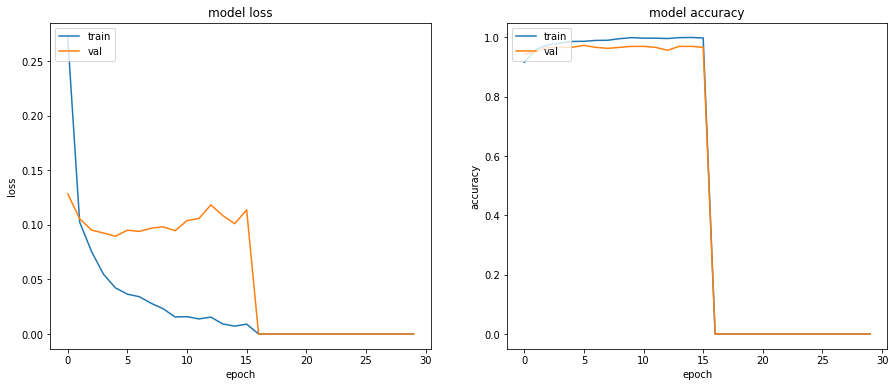

In [72]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [73]:
test_loss, test_acc = eval_model(modelo_vgg16_bn, test_data_loader_small, loss_fn=nn.BCEWithLogitsLoss())
print(f"El loss de test es {test_loss}, y el accuracy de test es de {test_acc:.3f}. ")
torch.save(modelo_vgg16_bn, "cats_and_dogs_small_bnorm_tl_finetune.pth")

El loss de test es 0.0795209670914337, y el accuracy de test es de 0.966. 


**Reducido - Base**

**0.00010**(18):  loss: 0.4271/0.4590/0.5503, accuracy: 78.88%/77.33%/73.60%

**Dropout**

**0.00010**(23):  loss: 0.4416/0.4551/0.5274, accuracy: 78.59%/78.67%/72.50%  (paro explícito)

**BatchNorm**

**0.00001**(08):  loss: 0.2852/0.4706,    accuracy: 94.06%/79.33%

**Dropout+BatchNorm**

**0.00010**(04):  loss: 0.4646/0.4795/0.5217,    accuracy: 77.82%/78.67%/74.00% (paro explícito)

**Dropout+BatchNorm+DataAugm**

**0.00100**(61):  loss: 0.4115/0.2940/0.3476,    accuracy: 80.71%/87.00%/84.70% (early stopping)

**TLearning - Feature Extraction**

**0.00001**(16):  loss: 0.0036/0.0404/0.0222,    accuracy: 99.94%/98.67%/99.40% (early stopping)

**TLearning - Fine-tuning**

**0.00001**(16):  loss: 0./0./0.,    accuracy: %/%/% (early stopping)

**Completo - Base**

**0.00001**(16):  loss: 0.1721/0.2149/0.0861,    accuracy: 93.02%/91.53%/97.30% (early stopping)
